In [93]:
#load packages

import numpy as np
import matplotlib.pyplot as pl
import h5py
import batman
import emcee
import george
import corner
import os
import glob
import sys
import io
import warnings
import logging
import ultranest
import pandas as pd
import pickle

from scipy import special
from scipy.stats import binned_statistic

In [94]:
# Set global font properties for all matplotlib plots
import matplotlib.pyplot as pl

# Configure global font settings
pl.rcParams['font.size'] = 17
pl.rcParams['axes.titlesize'] = 19
pl.rcParams['axes.labelsize'] = 17
pl.rcParams['xtick.labelsize'] = 16
pl.rcParams['ytick.labelsize'] = 16
pl.rcParams['legend.fontsize'] = 15
pl.rcParams['figure.titlesize'] = 21


# Optional: Change font family (uncomment if you want to change the font type)
# pl.rcParams['font.family'] = 'serif'  # Options: 'serif', 'sans-serif', 'monospace'
# pl.rcParams['font.serif'] = ['Times New Roman']  # Specific serif font
# pl.rcParams['font.sans-serif'] = ['Arial']  # Specific sans-serif font

print("Global font settings updated for all plots")

Global font settings updated for all plots


In [95]:
# Define the root directory containing all planet light curve folders
root_dir = "trappist_all_prepared_light_curve_files/"

# Only load TRAPPIST-1e_2023-06-22
selected_keys = ["TRAPPIST-1e_2023-06-22", "TRAPPIST-1e-1b_2025-10-29"]

file_list = []
for key in selected_keys:
    planet, date = key.split("_", 1)
    files = sorted(glob.glob(os.path.join(root_dir, planet, date, "prepared_light_curve.h5")))
    file_list.extend(files)

print(f"Found {len(file_list)} light curve files for selected keys: {selected_keys}")

# Load all data into a dictionary, removing NaNs from wavelength and corresponding fluxes
data_dict_flares_new = {}
for fn in file_list:
    planet = os.path.basename(os.path.dirname(os.path.dirname(fn)))
    date = os.path.basename(os.path.dirname(fn))
    key = f"{planet}_{date}"
    with h5py.File(fn, 'r') as f:
        mask = ~np.isnan(f['wavelength'][:])
        data_dict_flares_new[key] = {
            'bjd': f['bjd'][:],
            'bjd_binned': f['bjd_binned'][:],
            'flux': f['flux'][:, mask],
            'flux_binned': f['flux_binned'][:, mask],
            'flux_err': f['flux_err'][:, mask],
            'flux_err_binned': f['flux_err_binned'][:, mask],
            'it_index': f['it_index'][:],
            'it_index_non_binned': f['it_index_non_binned'][:],
            'oot_index': f['oot_index'][:],
            'oot_index_non_binned': f['oot_index_non_binned'][:],
            'wavelength': f['wavelength'][mask],
            'white_binned': f['white_binned'][:],
            'white_err_binned': f['white_err_binned'][:]
        }


Found 2 light curve files for selected keys: ['TRAPPIST-1e_2023-06-22', 'TRAPPIST-1e-1b_2025-10-29']


In [96]:
#Define FLARE MODEL

from scipy import special
from scipy.stats import binned_statistic

def flare_eqn(t,tpeak,fwhm,ampl):
    '''
    The equation that defines the shape for the Continuous Flare Model
    '''
    #Values were fit & calculated using MCMC 256 walkers and 30000 steps 
    #From Tovar Mendoza et al. (2022) DOI 10.3847/1538-3881/ac6fe6 (Llamaradas Estelares: Modeling the Morphology of White-Light Flares)

    A,B,C,D1,D2,f1 = [0.9687734504375167,-0.251299705922117,0.22675974948468916,
                      0.15551880775110513,1.2150539528490194,0.12695865022878844]

    # We include the corresponding errors for each parameter from the MCMC analysis

    A_err,B_err,C_err,D1_err,D2_err,f1_err = [0.007941622683556804,0.0004073709715788909,0.0006863488251125649,
                                              0.0013498012884345656,0.00453458098656645,0.001053149344530907 ]

    f2 = 1-f1

    eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)
                        * special.erfc(((B - t) / C) + (C * D1 / 2))) + ((1 / 2) * np.sqrt(np.pi) * A * C * f2
                        * np.exp(-D2 * t+ ((B / C) + (D2 * C / 2)) ** 2) * special.erfc(((B - t) / C) + (C * D2 / 2)))
    return eqn * ampl


def flare_model(t,tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Continuous Flare Model evaluated for single-peak (classical) flare events.
    Use this function for fitting classical flares with most curve_fit
    tools. Reference: Tovar Mendoza et al. (2022) DOI 10.3847/1538-3881/ac6fe6

    References
    --------------
    Tovar Mendoza et al. (2022) DOI 10.3847/1538-3881/ac6fe6
    Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Jackman et al. (2018) https://arxiv.org/abs/1804.03377

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over

    tpeak : float
        The center time of the flare peak

    fwhm : float
        The Full Width at Half Maximum, timescale of the flare

    ampl : float
        The amplitude of the flare


    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time

        A continuous flare template whose shape is defined by the convolution of a Gaussian and double exponential
        and can be parameterized by three parameters: center time (tpeak), FWHM, and ampitude
    '''

    t_new = (t-tpeak)/fwhm

    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new) - dt, max(t_new) + dt, t_new.size * uptime)

        flareup = flare_eqn(timeup,tpeak,fwhm,ampl)

        # and now downsample back to the original time...

        downbins = np.concatenate((t_new - dt / 2.,[max(t_new) + dt / 2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=np.sort(downbins))
    else:

        flare = flare_eqn(t_new,tpeak,fwhm,ampl)

    return flare

In [97]:
def bin_transmission_spectrum(wl, depth, depth_err, bin_width):
    """
    Bin a transmission spectrum into equal wavelength bins.

    Parameters:
    wl (array): Wavelengths in microns.
    depth (array): Transit depth measurements.
    depth_err (array): Errors on the transit depth measurements.
    bin_width (float): Desired width of each wavelength bin.

    Returns:
    wl_binned (array): Binned wavelength centers.
    depth_binned (array): Binned transit depths.
    depth_err_binned (array): Errors on the binned transit depths.
    """

    # Define bin edges
    wl_min, wl_max = np.min(wl), np.max(wl)
    bins = np.arange(wl_min, wl_max + bin_width, bin_width)
    
    # Initialize lists to store binned results
    wl_binned, depth_binned, depth_err_binned = [], [], []
    
    for i in range(len(bins) - 1):
        mask = (wl >= bins[i]) & (wl < bins[i + 1])
        
        if np.any(mask):  # If there are points in the bin
            wl_bin_center = np.mean(wl[mask])
            
            # Inverse variance weighting for depth
            weights = 1 / (depth_err[mask] ** 2)
            depth_mean = np.sum(weights * depth[mask]) / np.sum(weights)
            depth_err_mean = np.sqrt(1 / np.sum(weights))  # Propagate error
            
            wl_binned.append(wl_bin_center)
            depth_binned.append(depth_mean)
            depth_err_binned.append(depth_err_mean)
    
    return np.array(wl_binned), np.array(depth_binned), np.array(depth_err_binned)

# Set bin width in microns
bin_width = 0.1

In [98]:
import george
from george import kernels

def build_gp(sigma, l, time, flux_err):
    kernel = sigma**2 * kernels.Matern52Kernel(l)
    gp = george.GP(kernel)#, mean=mean_model)
    gp.compute(time, flux_err)   # factorize covariance matrix
    return gp

Offset list for TRAPPIST-1e_2023-06-22: [-0.06516036 -0.06085486 -0.05654936 -0.05224386 -0.04793837 -0.04363287
 -0.03932737 -0.03502187 -0.03071637 -0.02641088 -0.02210538 -0.01779988
 -0.01349438 -0.00918889  0.05539358  0.05969908  0.06400458  0.06831007
  0.07261557  0.07692107]
Number of offsets: 20


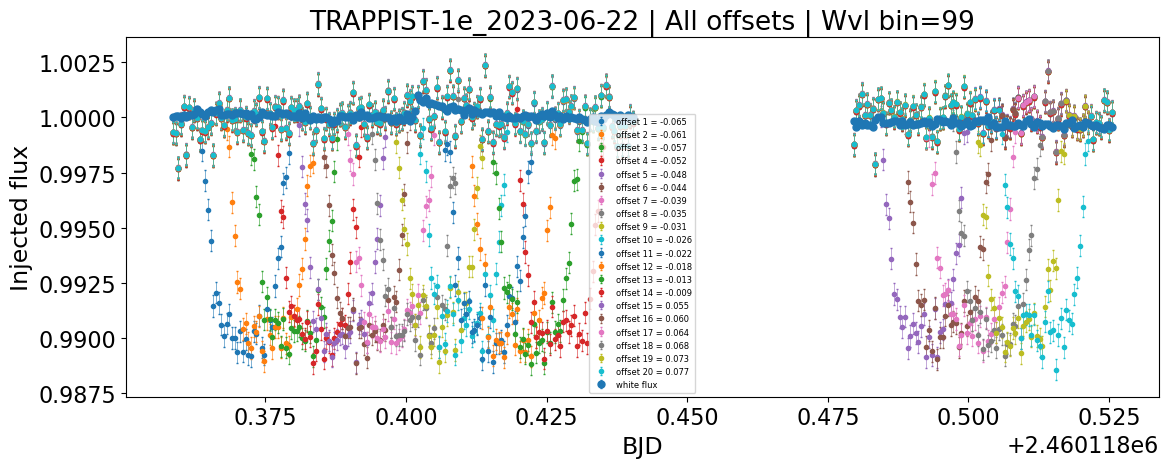

Offset list for TRAPPIST-1e-1b_2025-10-29: [-0.10267685 -0.0918352  -0.08099354 -0.07015189 -0.05931023 -0.04846857
 -0.03762692 -0.02678526 -0.01594361 -0.00510195  0.0057397   0.01658136
  0.02742301  0.03826467  0.04910632  0.05994797  0.07078963  0.08163128
  0.09247294  0.10331459]
Number of offsets: 20


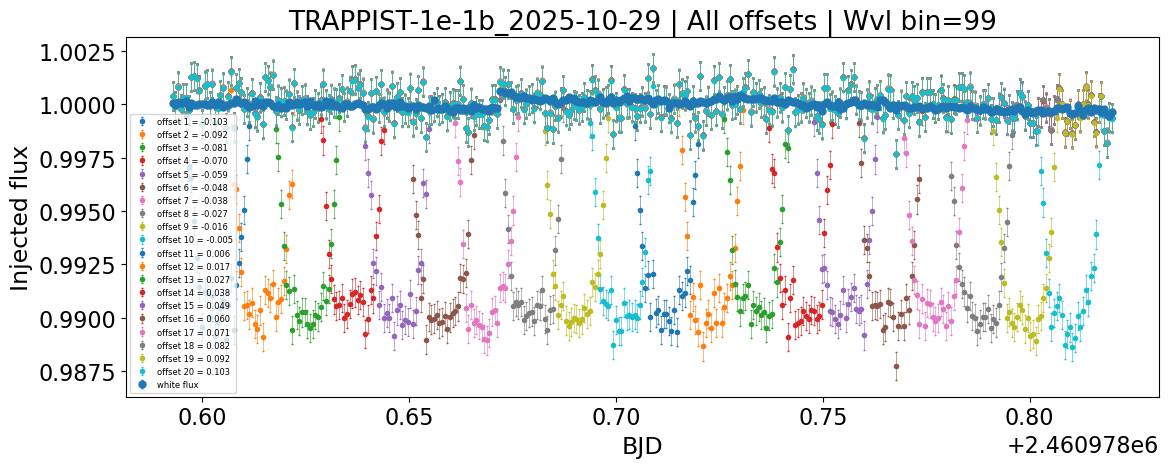

In [99]:
# Inject transit at various times in all bins and plot for selected light curves

offset_lists = {}

for key, d in data_dict_flares_new.items():
    # Mask out the transit for binned data
    it_index = d['it_index'].copy()
    padding = 7
    transit_indices = np.where(it_index == 1)[0]

    for t_idx in transit_indices:
        start = max(0, t_idx - padding)
        end = min(len(it_index), t_idx + padding + 1) 
        it_index[start:t_idx] = 1
        it_index[t_idx + 1:end] = 1

    # Get the out-of-transit bjd times
    bjd_binned_masked = d['bjd_binned'][it_index == 0]
    flux_binned_masked = d['flux_binned'][it_index == 0]
    flux_err_binned_masked = d['flux_err_binned'][it_index == 0]
    white_binned_masked = d['white_binned'][it_index == 0]
    white_err_binned_masked = d['white_err_binned'][it_index == 0]

    if key == "TRAPPIST-1e-1b_2025-10-29":
        # Find transit groups to identify 3rd and 4th transits
        transit_groups = []
        current_group = []
        for i, is_transit in enumerate(it_index):
            if is_transit:
                current_group.append(i)
            else:
                if current_group:
                    transit_groups.append(current_group)
                    current_group = []
        if current_group:  # Add last group if it exists
            transit_groups.append(current_group)

        if len(transit_groups) >= 4:
            # Get indices after 3rd transit and before 4th transit
            end_3rd_transit = transit_groups[2][-1]
            start_4th_transit = transit_groups[3][0]
            
            # Create mask for data between 3rd and 4th transits
            between_mask = np.arange(len(d['bjd_binned']))
            between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
            
            # Apply both out-of-transit mask and between-transits mask
            final_mask = (it_index == 0) & between_mask
            
            bjd_binned_masked = d['bjd_binned'][final_mask]
            flux_binned_masked = d['flux_binned'][final_mask]
            flux_err_binned_masked = d['flux_err_binned'][final_mask]
            white_binned_masked = d['white_binned'][final_mask]
            white_err_binned_masked = d['white_err_binned'][final_mask]

        N = 21 # number of offsets
        offset_list= bjd_binned_masked[::int(np.ceil( len(bjd_binned_masked) / N ))] 

        # remove offsets in the edges
        offset_list = offset_list[(offset_list > (bjd_binned_masked.min() + 0.005)) & (offset_list < (bjd_binned_masked.max() - 0.005))]

        offset_list = offset_list - np.mean(bjd_binned_masked)
            
    else:
        N = 30 # number of offsets
        offset_list= bjd_binned_masked[::int(np.ceil( len(bjd_binned_masked) / N ))] 

        # remove offsets in the edges
        offset_list = offset_list[(offset_list > (bjd_binned_masked.min() + 0.01)) & (offset_list < (bjd_binned_masked.max() - 0.01))]
        
        # remove offsets close to transit

        bjd_binned_it = d['bjd_binned'][it_index == 1]

        offset_list = offset_list[(offset_list < (bjd_binned_it.min() - 0.01)) | (offset_list > (bjd_binned_it.max() + 0.01))]
        #print(bjd_binned_it.min(), bjd_binned_it.max())

        offset_list = offset_list - np.mean(bjd_binned_masked)

    if key == "TRAPPIST-1g_2022-12-12":
        offset_list = offset_list[1:-1]  # Remove first and last to keep the same number of offsets as other light curves

    #offset_list = [-0.02]  # Manually set offsets for testing
    print(f'Offset list for {key}:', offset_list)
    print('Number of offsets:', len(offset_list))

    offset_lists[key] = offset_list

    pl.figure(figsize=(12, 5))
    for jdx,j in enumerate(offset_lists[key]):

        params = batman.TransitParams()
        params.t0 = np.mean(bjd_binned_masked)+j    #time of inferior conjunction
        params.per = 1.                             #orbital period
        params.a = 15.                              #semi-major axis (in units of stellar radii)
        params.inc = 87.                            #orbital inclination (in degrees)
        params.ecc = 0.                             #eccentricity
        params.w = 90.                              #longitude of periastron (in degrees)
        params.u = [0.1, 0.3]                       #limb darkening coefficients [u1, u2]
        params.limb_dark = "quadratic"              #limb darkening model

        # -----------------------------------------------
        # Inject CHROMATIC transit depths
        # -----------------------------------------------

        # Define chromatic feature
        Rp0 = 0.1            # baseline radius ratio
        A = 0.002            # amplitude of spectral feature  
        lambda0 = 3.5        # center of feature [micron]
        sigma_lambda = 0.3   # width of Gaussian [micron]

        wavelengths = d['wavelength']  # array of wavelength bins

        # Compute chromatic Rp(λ)
        Rp_lambda = Rp0 + A * np.exp(-0.5 * ((wavelengths - lambda0) / sigma_lambda)**2)

        # Inject chromatic transit model
        flux_binned_masked_injected = np.zeros_like(flux_binned_masked)

        for i in range(flux_binned_masked.shape[1]):
            # update transit parameters for this wavelength
            params.rp = Rp_lambda[i]

            m = batman.TransitModel(params, bjd_binned_masked)
            chromatic_flux = m.light_curve(params)

            baseline_mask = (chromatic_flux == 1.0)

            # injection: remove original baseline, add chromatic transit model
            flux_binned_masked_injected[:, i] = (flux_binned_masked[:, i] - np.median(flux_binned_masked[baseline_mask, i]) + chromatic_flux)


        # Plot one wavelength bin for each offset
        for i in np.linspace(100, flux_binned_masked.shape[1] - 100, 1):
            pl.errorbar(bjd_binned_masked, flux_binned_masked_injected[:, int(i) - 1], 
                        flux_err_binned_masked[:, int(i) - 1],
                        fmt='o', capsize=0.4, markersize=3, elinewidth=0.4, 
                        label=f'offset {jdx+1} = {j:.3f}')

    # Plot white flux once
    pl.errorbar(bjd_binned_masked, white_binned_masked, white_err_binned_masked, 
                fmt='o', capsize=0.5, markersize=5, elinewidth=0.5, label='white flux')
    pl.title(f"{key} | All offsets | Wvl bin={int(i) - 1}")
    pl.xlabel('BJD')
    pl.ylabel('Injected flux')
    pl.legend(fontsize=6)#, loc='lower left')
    pl.tight_layout()
    pl.show()

In [100]:
print("Offset lists for all keys:", offset_lists)

Offset lists for all keys: {'TRAPPIST-1e_2023-06-22': array([-0.06516036, -0.06085486, -0.05654936, -0.05224386, -0.04793837,
       -0.04363287, -0.03932737, -0.03502187, -0.03071637, -0.02641088,
       -0.02210538, -0.01779988, -0.01349438, -0.00918889,  0.05539358,
        0.05969908,  0.06400458,  0.06831007,  0.07261557,  0.07692107]), 'TRAPPIST-1e-1b_2025-10-29': array([-0.10267685, -0.0918352 , -0.08099354, -0.07015189, -0.05931023,
       -0.04846857, -0.03762692, -0.02678526, -0.01594361, -0.00510195,
        0.0057397 ,  0.01658136,  0.02742301,  0.03826467,  0.04910632,
        0.05994797,  0.07078963,  0.08163128,  0.09247294,  0.10331459])}


In [101]:
# --- Statistical evaluation using Nested Sampling (Ultranest) ---

# Helper context manager to silence stdout/stderr & warnings
from contextlib import redirect_stdout, redirect_stderr, contextmanager

@contextmanager
def silence_all():
    """Context manager that silences stdout, stderr, warnings, numpy floating warnings,
    and lowers ultranest logging. Use around the sampler.run(...) call."""
    # save state
    devnull = open(os.devnull, "w")
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    old_warn_filters = warnings.filters[:]  # copy current filters
    old_log_levels = {}
    # target loggers to quiet (ultranest prints via its own logger & via stdout)
    targets = ['ultranest', 'matplotlib', 'numba', 'parso']  # add others if needed
    for name in targets:
        old_log_levels[name] = logging.getLogger(name).level
        logging.getLogger(name).setLevel(logging.CRITICAL)

    old_errstate = np.seterr()         # numpy error handling
    try:
        # redirect stdout/stderr
        sys.stdout = devnull
        sys.stderr = devnull
        # silence python warnings
        warnings.simplefilter("ignore")
        # silence numpy floating warnings too
        np.seterr(all='ignore')
        yield
    finally:
        # restore
        sys.stdout = old_stdout
        sys.stderr = old_stderr
        warnings.filters = old_warn_filters
        np.seterr(**old_errstate)
        for name, lvl in old_log_levels.items():
            logging.getLogger(name).setLevel(lvl)
        devnull.close()

# --- Define nested sampling functions ---
def run_nested_flat(depth, depth_err):
    """
    depth: 1D array of transit depths (ppm)
    depth_err: 1D array uncertainties (ppm)
    returns: (logZ, logZ_err, result_dict_from_ultranest)
    """
    mean_depth = np.mean(depth)
    sd = np.std(depth)
    # priors for flat model: m ~ Uniform(min-5sigma, max+5sigma)
    m_min = np.min(depth) - 5.0 * max(sd, 1e-6)
    m_max = np.max(depth) + 5.0 * max(sd, 1e-6)

    def prior_transform(u):
        u = np.atleast_1d(u)
        if u.ndim == 1:
            return np.array([m_min + u[0] * (m_max - m_min)])
        else:
            return np.array([m_min + u[:, 0] * (m_max - m_min)]).T

    def loglike(params):
        m = params[0]
        resid = depth - m
        invvar = 1.0 / (depth_err ** 2)
        return -0.5 * np.sum(resid * resid * invvar + np.log(2.0 * np.pi / invvar))
    
    with silence_all():
        sampler = ultranest.ReactiveNestedSampler(['m'], loglike, prior_transform)
        res = sampler.run(min_num_live_points=400, dlogz=0.5, show_status=False, viz_callback=False)

    return res['logz'], res['logzerr'], res


def run_nested_gaussian(wl, depth, depth_err):
    """
    depth: 1D array of transit depths (ppm)
    depth_err: 1D array uncertainties (ppm)
    wl: wavelength array (same length as depth)
    gaussian feature model: depth = baseline + amplitude * exp(-0.5 * ((wl - center) / sigma)^2)
    returns: (logZ, logZ_err, result_dict_from_ultranest)
    """
    mean_depth = np.mean(depth)
    sd = np.std(depth)
        
    # Prior bounds
    #baseline_min = mean_depth - 5.0 * max(sd, 1e-6)
    #baseline_max = mean_depth + 5.0 * max(sd, 1e-6)
    #amplitude_min = 0.0  # Only allow emission features (positive amplitude)
    #amplitude_max = 2.0 * max(sd, 1e-6)
    #print('amplitude_max:', amplitude_max)
    #center_min = 3.0  # [microns]
    #center_max = 4.0  # [microns]
    #sigma_min = 0.1  # Minimum width [microns]
    #sigma_max = 0.5  # Maximum width [microns]

    baseline_min = mean_depth - 5.0 * max(sd, 1e-6)
    baseline_max = mean_depth + 5.0 * max(sd, 1e-6)
    amplitude_min = 300  # Only allow emission features (positive amplitude)
    amplitude_max = 500  #2.0 * max(sd, 1e-6)
    center_min = 3.3  # [microns]
    center_max = 3.7  # [microns]
    sigma_min = 0.2  # Minimum width [microns]
    sigma_max = 0.4  # Maximum width [microns]

    def prior_transform(u):
        u = np.atleast_1d(u)
        if u.ndim == 1:
            baseline = baseline_min + u[0] * (baseline_max - baseline_min)
            amplitude = amplitude_min + u[1] * (amplitude_max - amplitude_min)
            center = center_min + u[2] * (center_max - center_min)
            sigma = sigma_min + u[3] * (sigma_max - sigma_min)
            return np.array([baseline, amplitude, center, sigma])
        else:
            baseline = baseline_min + u[:, 0] * (baseline_max - baseline_min)
            amplitude = amplitude_min + u[:, 1] * (amplitude_max - amplitude_min)
            center = center_min + u[:, 2] * (center_max - center_min)
            sigma = sigma_min + u[:, 3] * (sigma_max - sigma_min)
            return np.stack([baseline, amplitude, center, sigma], axis=-1)

    def loglike(params):
        baseline, amplitude, center, sigma = params
        model = baseline + amplitude * np.exp(-0.5 * ((wl - center) / sigma) ** 2)
        resid = depth - model
        invvar = 1.0 / (depth_err ** 2)
        return -0.5 * np.sum(resid * resid * invvar + np.log(2.0 * np.pi / invvar))

    with silence_all():
        sampler = ultranest.ReactiveNestedSampler(['baseline', 'amplitude', 'center', 'sigma'], loglike, prior_transform)
        res = sampler.run(min_num_live_points=400, dlogz=0.5, show_status=False, viz_callback=False)
    
    return res['logz'], res['logzerr'], res



for idx, (key, d) in enumerate(data_dict_flares_new.items()):
    # Create directory for nested sampling results
    os.makedirs(f'outputs/nested_results_feature/{key}', exist_ok=True)
    print(f"\nEvaluation of results for {key} (unbinned spectra)")

    wavelength = d['wavelength']
    mask = ~np.isnan(wavelength)
    wl_masked = wavelength[mask]

    slice_start, slice_end = 55, len(wl_masked) - 40
    wl_masked_sliced = wl_masked[slice_start:slice_end]

    if idx == 0:
        all_results_nested = {}

    if key not in all_results_nested:
        all_results_nested[key] = []

    for jdx, j in enumerate(offset_lists[key]):
        # --- File names for all models ---
        if key == "TRAPPIST-1e_2023-06-22":
            output_filename_gp = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'
            nested_results_file = f'outputs/nested_results_feature/{key}/{key}_{j:.5f}_nested_feature.pkl'
        else:
            output_filename_gp = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'
            nested_results_file = f'outputs/nested_results_feature/{key}/{key}_{j:.5f}_nested_feature.pkl'

        # Check if results already exist
        if os.path.exists(nested_results_file):
            print(f"Loading existing nested sampling results for offset {jdx+1} = {j:.3f}")
            with open(nested_results_file, 'rb') as f:
                offset_results = pickle.load(f)
        else:
            # --- Helper to load and slice results ---
            def load_results(filename, mask, slice_start, slice_end):
                data = np.loadtxt(filename, delimiter=',', skiprows=1)
                rp, rp_err = data[:, 0], data[:, 1]
                rp_masked = rp[mask][slice_start:slice_end]
                rp_err_masked = rp_err[mask][slice_start:slice_end]
                return rp_masked, rp_err_masked

            # --- Load all three models ---
            rp_masked_gp, rp_err_masked_gp = load_results(output_filename_gp, mask, slice_start, slice_end)

            wl = wl_masked_sliced

            models = {"+ gp": (rp_masked_gp, rp_err_masked_gp)}

            # Dictionary to store results for this offset
            offset_results = {"Offset": f"{jdx+1} = {j:.3f}"}

            # --- Run for each model type ---
            for model_name, (rp_masked, rp_err_masked) in models.items():
                depth = rp_masked ** 2 * 1e6
                depth_err = 2 * rp_masked * rp_err_masked * 1e6

                logz_flat, logzflat_err, res_flat = run_nested_flat(depth, depth_err)
                logz_gauss, logzgauss_err, res_gauss = run_nested_gaussian(wl, depth, depth_err)
                delta_logz = logz_gauss - logz_flat

                # --- Jeffreys scale interpretation ---
                if delta_logz > 5:
                    interpretation = "Non-flat (Gaussian): strong evidence"
                    preferred_model = "gaussian"
                elif delta_logz > 2:
                    interpretation = "Non-flat (Gaussian): moderate evidence"
                    preferred_model = "gaussian"
                elif delta_logz > 1:
                    interpretation = "Non-flat (Gaussian): weak evidence"
                    preferred_model = "gaussian"
                elif delta_logz < -1:
                    interpretation = "Flat: weak evidence"
                    preferred_model = "flat"
                elif delta_logz < -2:
                    interpretation = "Flat: moderate evidence"
                    preferred_model = "flat"
                elif delta_logz < -5:
                    interpretation = "Flat: strong evidence"
                    preferred_model = "flat"
                else:
                    interpretation = "Inconclusive"
                    preferred_model = "inconclusive"

                # Store results (ΔlogZ and interpretation first)
                offset_results[f"ΔlogZ ({model_name})"] = delta_logz
                offset_results[f"Interpretation ({model_name})"] = interpretation
                
                # Store model parameters separately (will be reordered later)
                if preferred_model == "gaussian":
                    # Get median and std from posterior samples
                    samples = res_gauss['samples']
                    baseline_median = np.median(samples[:, 0])
                    baseline_std = np.std(samples[:, 0])
                    amplitude_median = np.median(samples[:, 1])
                    amplitude_std = np.std(samples[:, 1])
                    center_median = np.median(samples[:, 2])
                    center_std = np.std(samples[:, 2])
                    sigma_median = np.median(samples[:, 3])
                    sigma_std = np.std(samples[:, 3])
                    
                    offset_results[f"Baseline ({model_name})"] = baseline_median
                    offset_results[f"Baseline_err ({model_name})"] = baseline_std
                    offset_results[f"Amplitude ({model_name})"] = amplitude_median
                    offset_results[f"Amplitude_err ({model_name})"] = amplitude_std
                    offset_results[f"Center ({model_name})"] = center_median
                    offset_results[f"Center_err ({model_name})"] = center_std
                    offset_results[f"Sigma ({model_name})"] = sigma_median
                    offset_results[f"Sigma_err ({model_name})"] = sigma_std
                    
                elif preferred_model == "flat" or preferred_model == "inconclusive":
                    # Get median and std from posterior samples
                    samples = res_flat['samples']
                    mean_depth_median = np.median(samples[:, 0])
                    mean_depth_std = np.std(samples[:, 0])
                    
                    offset_results[f"Mean_Depth ({model_name})"] = mean_depth_median
                    offset_results[f"Mean_Depth_err ({model_name})"] = mean_depth_std

            # Save results
            with open(nested_results_file, 'wb') as f:
                pickle.dump(offset_results, f)

        all_results_nested[key].append(offset_results)

    # --- Display summary table for this light curve with reordered columns ---
    table = pd.DataFrame(all_results_nested[key])
    
    # Reorder columns: Offset, then ΔlogZ and Interpretation columns, then model parameters
    cols = list(table.columns)
    main_cols = ['Offset']
    delta_interp_cols = [c for c in cols if 'ΔlogZ' in c or 'Interpretation' in c]
    param_cols = [c for c in cols if c not in main_cols and c not in delta_interp_cols]
    
    table = table[main_cols + delta_interp_cols + param_cols]
    
    display(table)


Evaluation of results for TRAPPIST-1e_2023-06-22 (unbinned spectra)


Offset  ΔlogZ (+ gp)                 Interpretation (+ gp)  \
0    1 = -0.065      7.439229  Non-flat (Gaussian): strong evidence   
1    2 = -0.061     10.131503  Non-flat (Gaussian): strong evidence   
2    3 = -0.057     15.429163  Non-flat (Gaussian): strong evidence   
3    4 = -0.052     17.909085  Non-flat (Gaussian): strong evidence   
4    5 = -0.048     18.831142  Non-flat (Gaussian): strong evidence   
5    6 = -0.044     19.686827  Non-flat (Gaussian): strong evidence   
6    7 = -0.039     27.925148  Non-flat (Gaussian): strong evidence   
7    8 = -0.035     30.233659  Non-flat (Gaussian): strong evidence   
8    9 = -0.031     24.368385  Non-flat (Gaussian): strong evidence   
9   10 = -0.026     30.095578  Non-flat (Gaussian): strong evidence   
10  11 = -0.022     13.514379  Non-flat (Gaussian): strong evidence   
11  12 = -0.018      9.974759  Non-flat (Gaussian): strong evidence   
12  13 = -0.013      9.138510  Non-flat (Gaussian): strong evidence   
13  14 = -0.009      8.918512  Non-flat (Gaussian): strong evidence   
14   15 = 0.055     32.589639  Non-flat (Gaussian): strong evidence   
15   16 = 0.060     23.025129  Non-flat (Gaussian): strong evidence   
16   17 = 0.064     14.728275  Non-flat (Gaussian): strong evidence   
17   18 = 0.068      8.124138  Non-flat (Gaussian): strong evidence   
18   19 = 0.073     12.894854  Non-flat (Gaussian): strong evidence   
19   20 = 0.077     16.208737  Non-flat (Gaussian): strong evidence   

    Baseline (+ gp)  Baseline_err (+ gp)  Amplitude (+ gp)  \
0       9944.433780            17.354063        327.228395   
1       9978.564156            16.844679        328.306830   
2      10021.518020            16.520088        368.829448   
3      10057.266476            16.292869        384.569416   
4      10035.284098            17.564546        376.583454   
5      10023.242708            18.491757        370.905494   
6      10063.520129            18.095885        417.201554   
7      10100.441066            20.354650        457.273678   
8      10023.270554            26.757382        465.786946   
9       9876.609633            20.667516        441.148989   
10      9956.990122            16.834707        331.661557   
11      9984.550487            16.884732        322.754029   
12      9987.373628            16.983530        328.872234   
13      9979.204461            18.199678        329.149472   
14      9971.921227            17.955332        438.890841   
15      9944.202442            17.568291        384.192725   
16      9945.867466            16.643708        348.977528   
17      9970.591292            16.330771        329.027194   
18      9991.127482            17.308388        337.025494   
19     10006.253107            18.459384        357.271874   

    Amplitude_err (+ gp)  Center (+ gp)  Center_err (+ gp)  Sigma (+ gp)  \
0              29.359358       3.534511           0.078626      0.279542   
1              30.684489       3.496037           0.074171      0.290405   
2              46.865064       3.464288           0.049840      0.234117   
3              49.228539       3.440834           0.046709      0.233883   
4              47.880812       3.436752           0.053982      0.268727   
5              45.142906       3.475278           0.064036      0.316613   
6              46.550351       3.496258           0.055819      0.328656   
7              37.635460       3.616108           0.053372      0.362913   
8              35.183242       3.634225           0.049501      0.352598   
9              41.731663       3.611311           0.050982      0.357020   
10             32.972271       3.561994           0.071528      0.316209   
11             26.831320       3.424148           0.074678      0.329998   
12             29.930144       3.486065           0.073408      0.276070   
13             31.480002       3.514841           0.072188      0.276365   
14             41.756545       3.575359           0.052806      0.349567  


Evaluation of results for TRAPPIST-1e-1b_2025-10-29 (unbinned spectra)


Offset  ΔlogZ (+ gp)                   Interpretation (+ gp)  \
0    1 = -0.103      9.135790    Non-flat (Gaussian): strong evidence   
1    2 = -0.092     20.134145    Non-flat (Gaussian): strong evidence   
2    3 = -0.081     35.236689    Non-flat (Gaussian): strong evidence   
3    4 = -0.070     25.142733    Non-flat (Gaussian): strong evidence   
4    5 = -0.059     25.413944    Non-flat (Gaussian): strong evidence   
5    6 = -0.048     27.806196    Non-flat (Gaussian): strong evidence   
6    7 = -0.038     44.378541    Non-flat (Gaussian): strong evidence   
7    8 = -0.027     24.745416    Non-flat (Gaussian): strong evidence   
8    9 = -0.016      6.835319    Non-flat (Gaussian): strong evidence   
9   10 = -0.005      3.788241  Non-flat (Gaussian): moderate evidence   
10   11 = 0.006      2.936389  Non-flat (Gaussian): moderate evidence   
11   12 = 0.017     15.773349    Non-flat (Gaussian): strong evidence   
12   13 = 0.027     33.553740    Non-flat (Gaussian): strong evidence   
13   14 = 0.038     37.653919    Non-flat (Gaussian): strong evidence   
14   15 = 0.049     24.910950    Non-flat (Gaussian): strong evidence   
15   16 = 0.060     26.900676    Non-flat (Gaussian): strong evidence   
16   17 = 0.071     41.555761    Non-flat (Gaussian): strong evidence   
17   18 = 0.082     32.878196    Non-flat (Gaussian): strong evidence   
18   19 = 0.092      4.719735  Non-flat (Gaussian): moderate evidence   
19   20 = 0.103     23.382376    Non-flat (Gaussian): strong evidence   

    Baseline (+ gp)  Baseline_err (+ gp)  Amplitude (+ gp)  \
0      10027.312631            18.704361        337.822143   
1       9998.395102            17.525448        364.058490   
2       9956.351849            17.034683        438.118086   
3       9993.383395            17.893209        381.100476   
4       9972.166497            17.910332        373.489319   
5      10111.532298            18.045448        399.179164   
6      10129.437938            17.530541        468.970180   
7       9860.518783            20.413400        419.822651   
8       9971.363729            15.983990        328.178576   
9       9946.278676            15.536573        321.353598   
10     10075.269390            15.745813        318.657312   
11      9942.279032            16.702940        359.133695   
12      9806.871562            17.740276        404.847467   
13     10033.628463            17.043985        453.440244   
14     10011.736601            17.646784        383.697082   
15      9967.506785            16.462331        421.203668   
16      9976.083866            16.944951        450.571612   
17      9998.978254            17.559723        416.595392   
18     10102.260701            17.631428        319.620928   
19      9980.856720            19.807016        415.546353   

    Amplitude_err (+ gp)  Center (+ gp)  Center_err (+ gp)  Sigma (+ gp)  \
0              37.519666       3.531385           0.072125      0.271296   
1              45.551963       3.404917           0.052858      0.285108   
2              41.988935       3.559792           0.047559      0.313969   
3              47.078545       3.536620           0.056078      0.302833   
4              43.126487       3.554944           0.062337      0.352912   
5              48.128982       3.405280           0.051494      0.326379   
6              29.208272       3.530357           0.057059      0.385835   
7              46.762801       3.586618           0.052251      0.297710   
8              29.393188       3.583923           0.052322      0.226392   
9              25.290483       3.494255           0.057705      0.220142   
10             22.269128       3.418641           0.061779      0.234578   
11             43.510322       3.459783           0.050228      0.242755   
12             43.707385       3.465862           0.060124      0.366183   
13             37.037671       3.559881           0.044754      0.302358   
14             47.586084       3

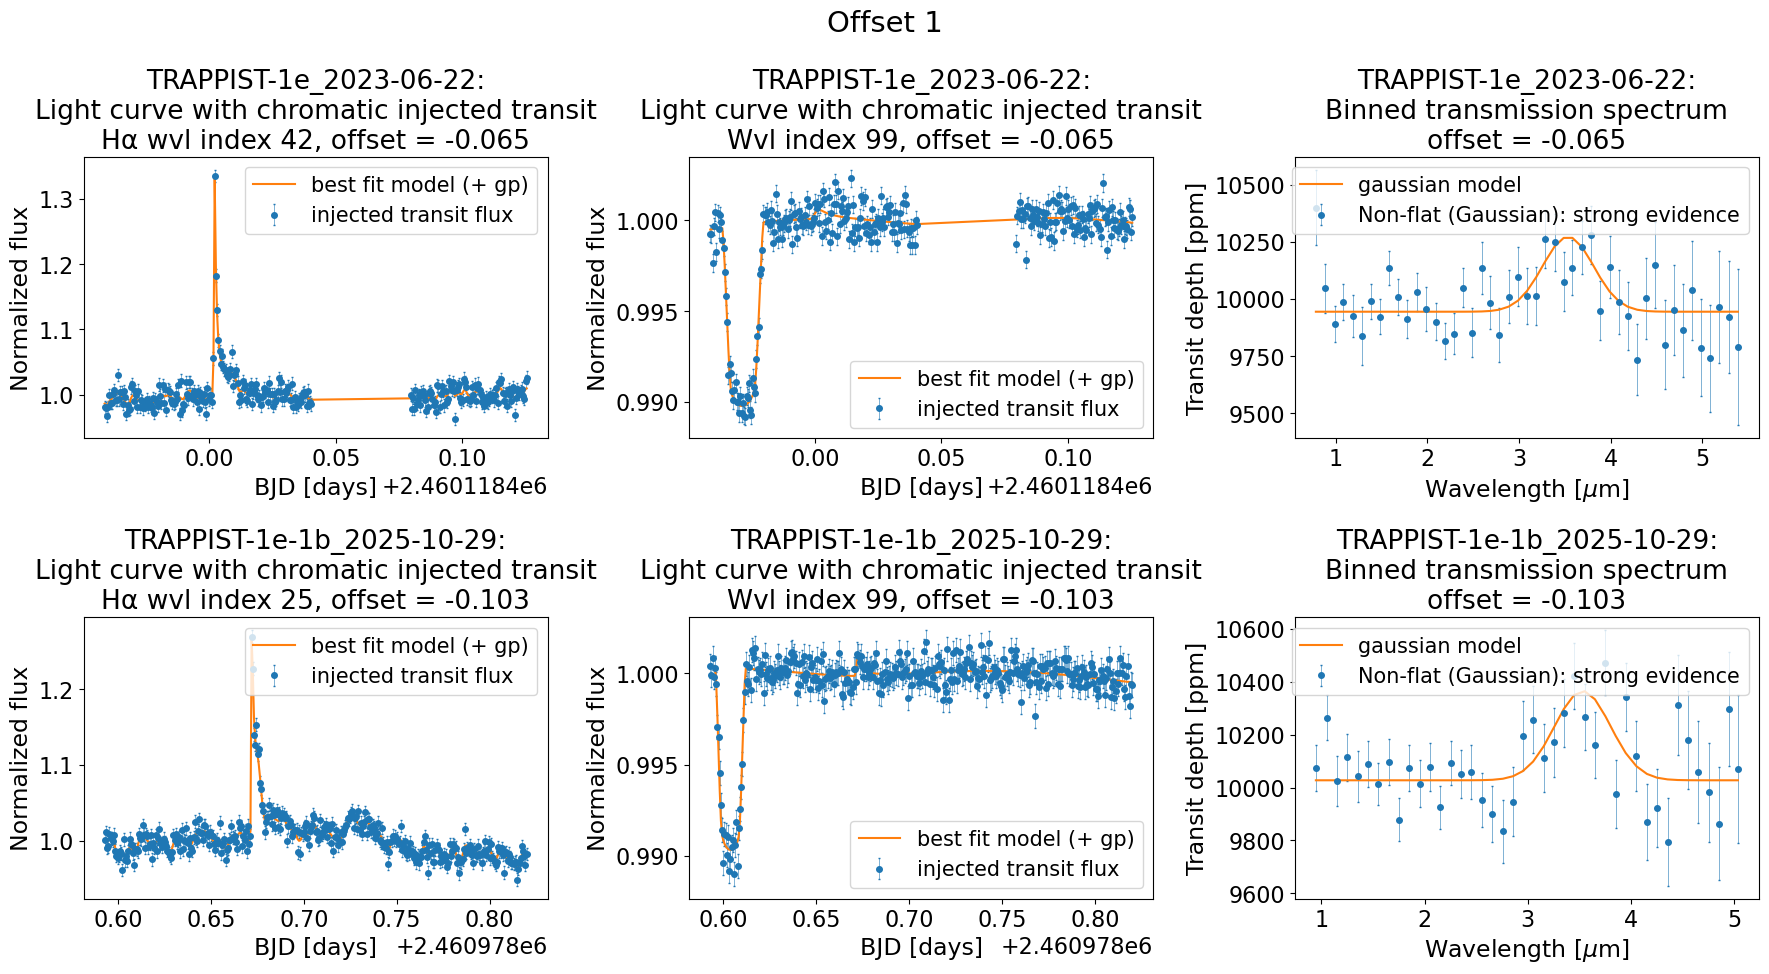

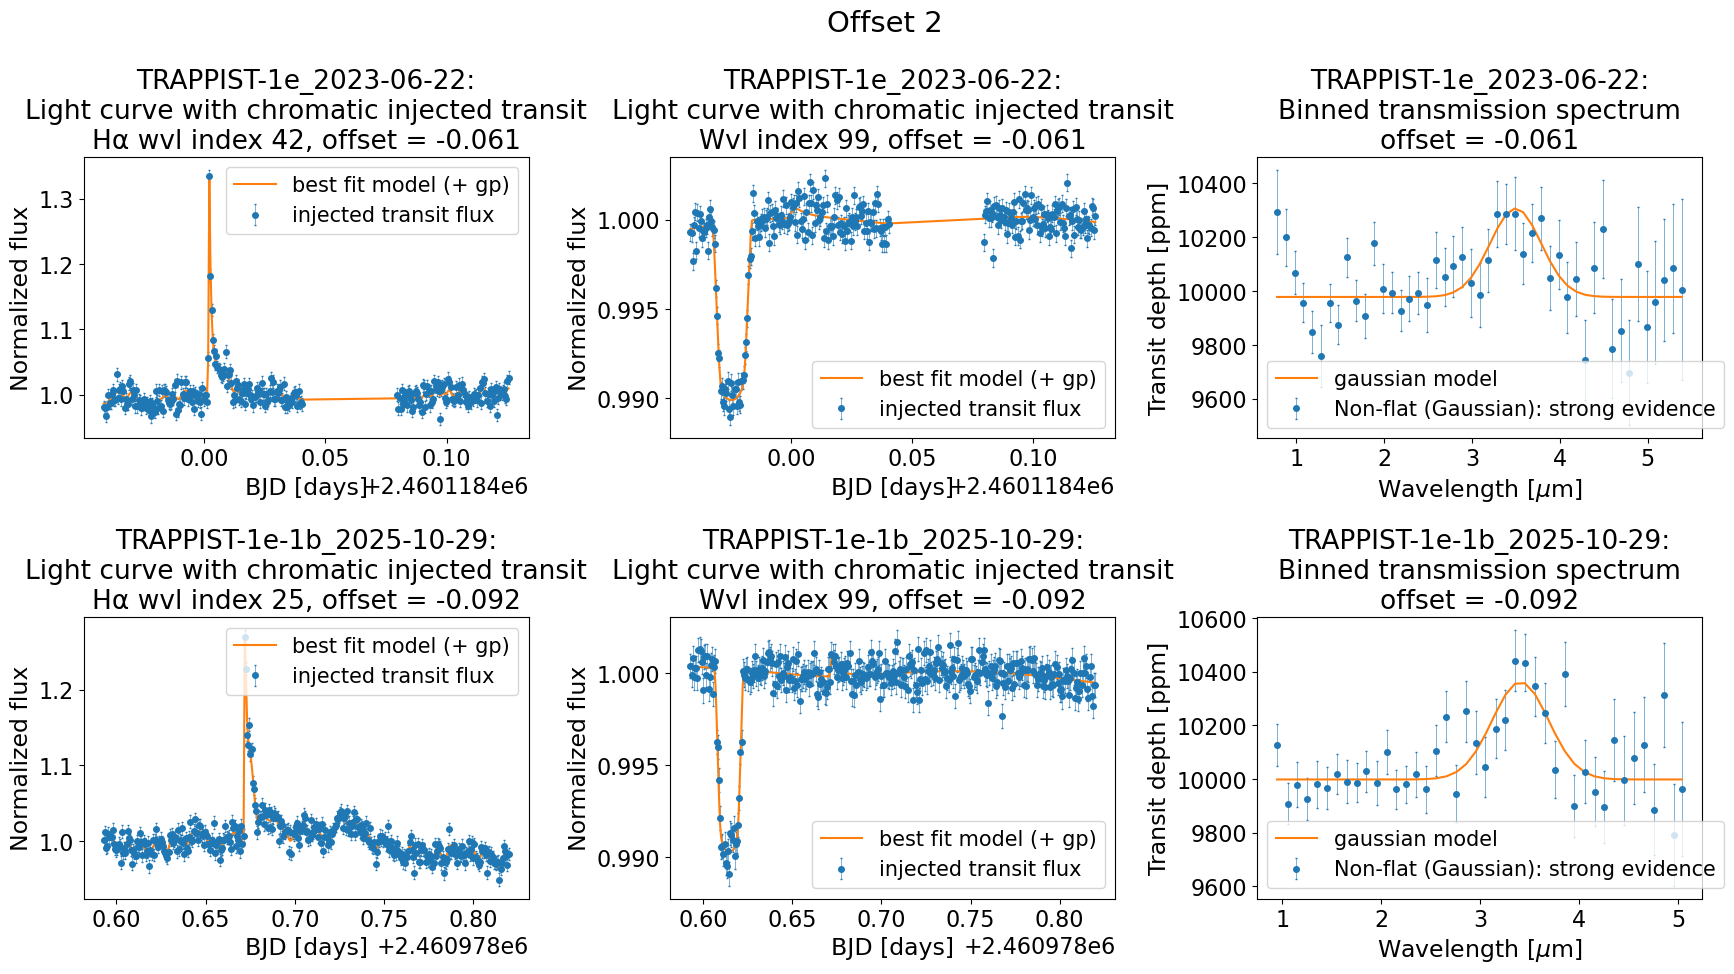

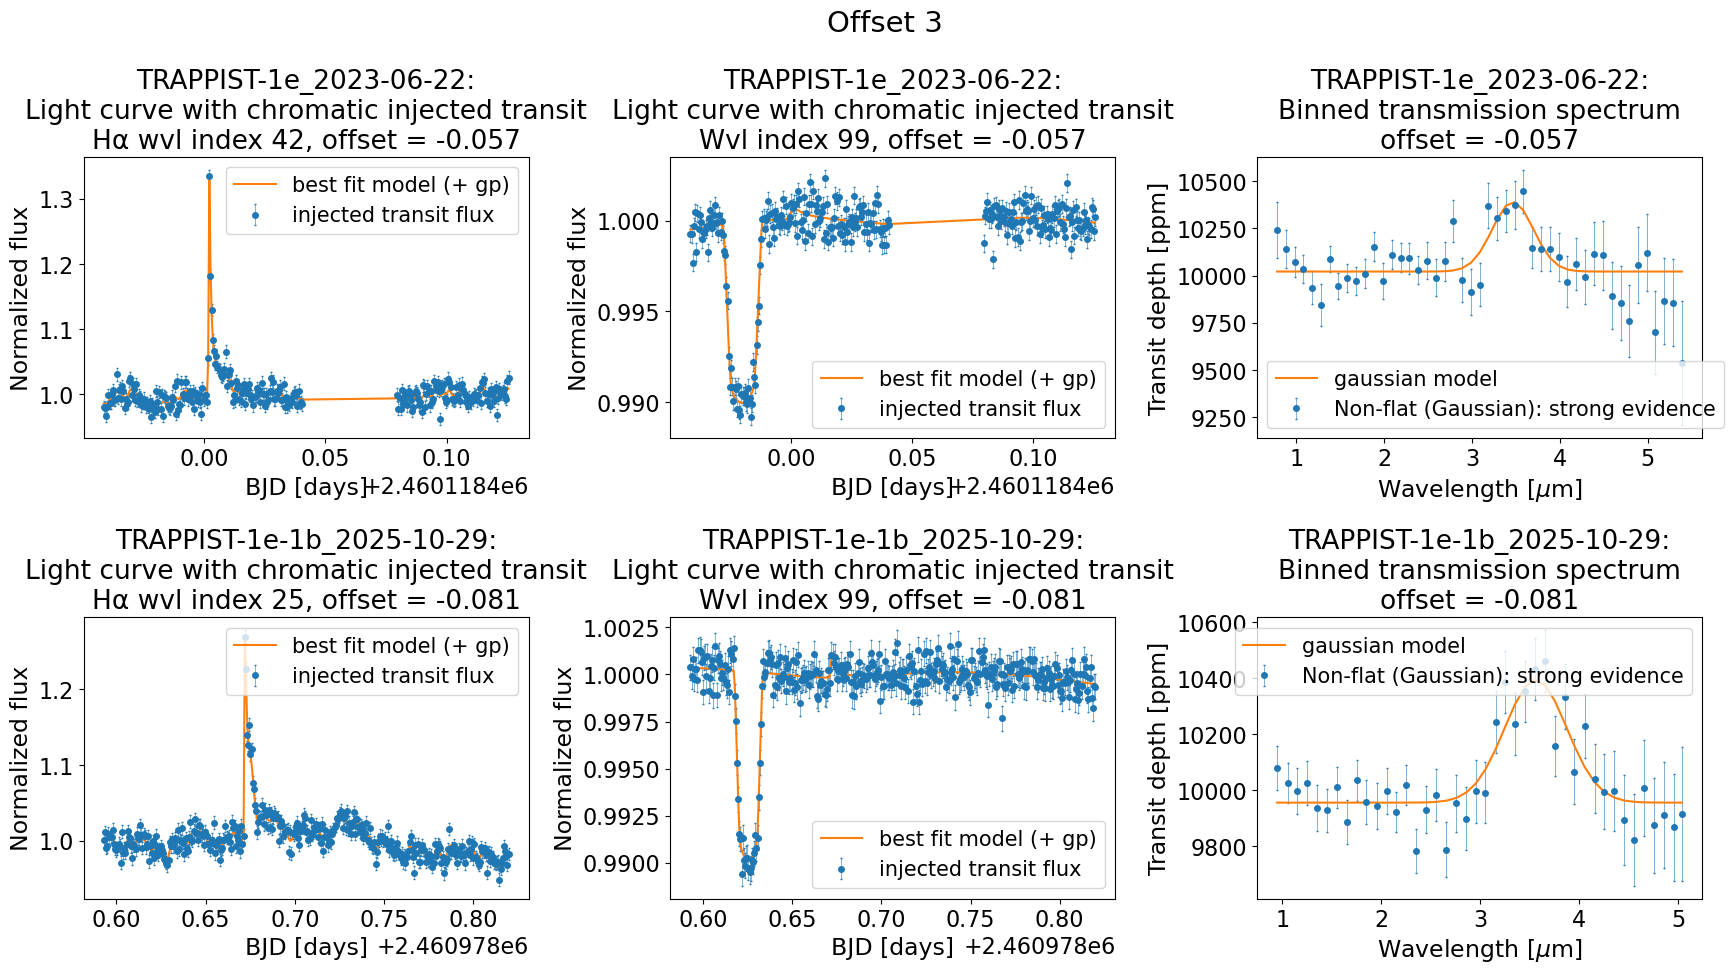

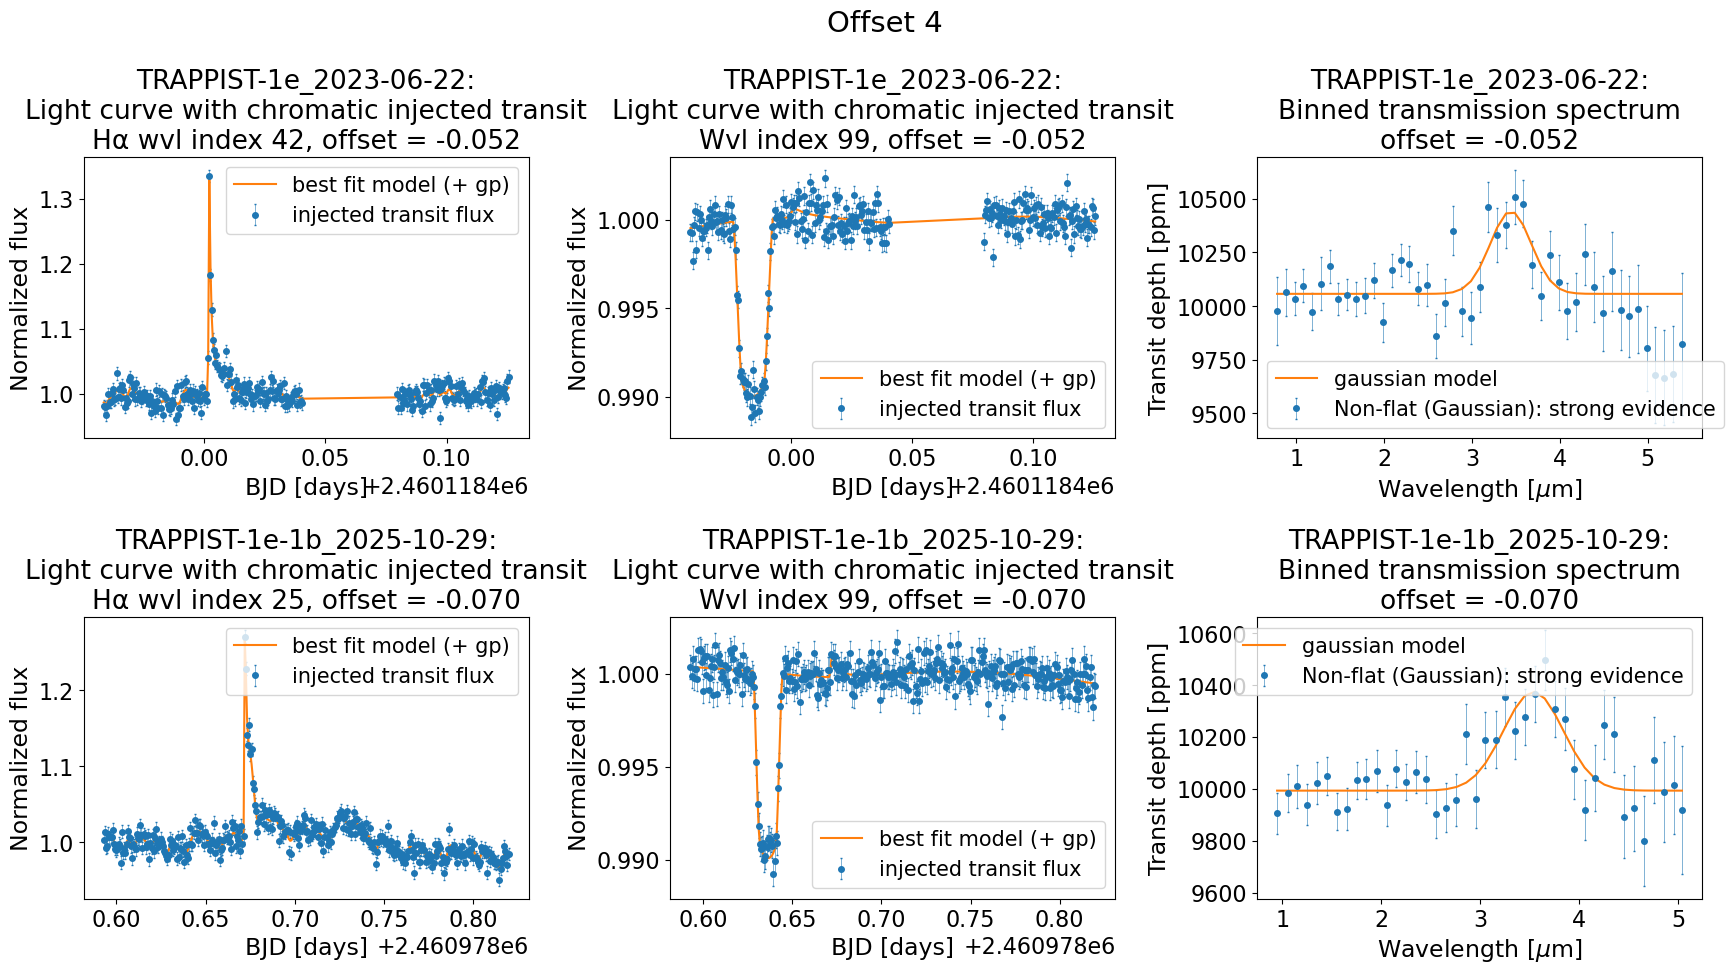

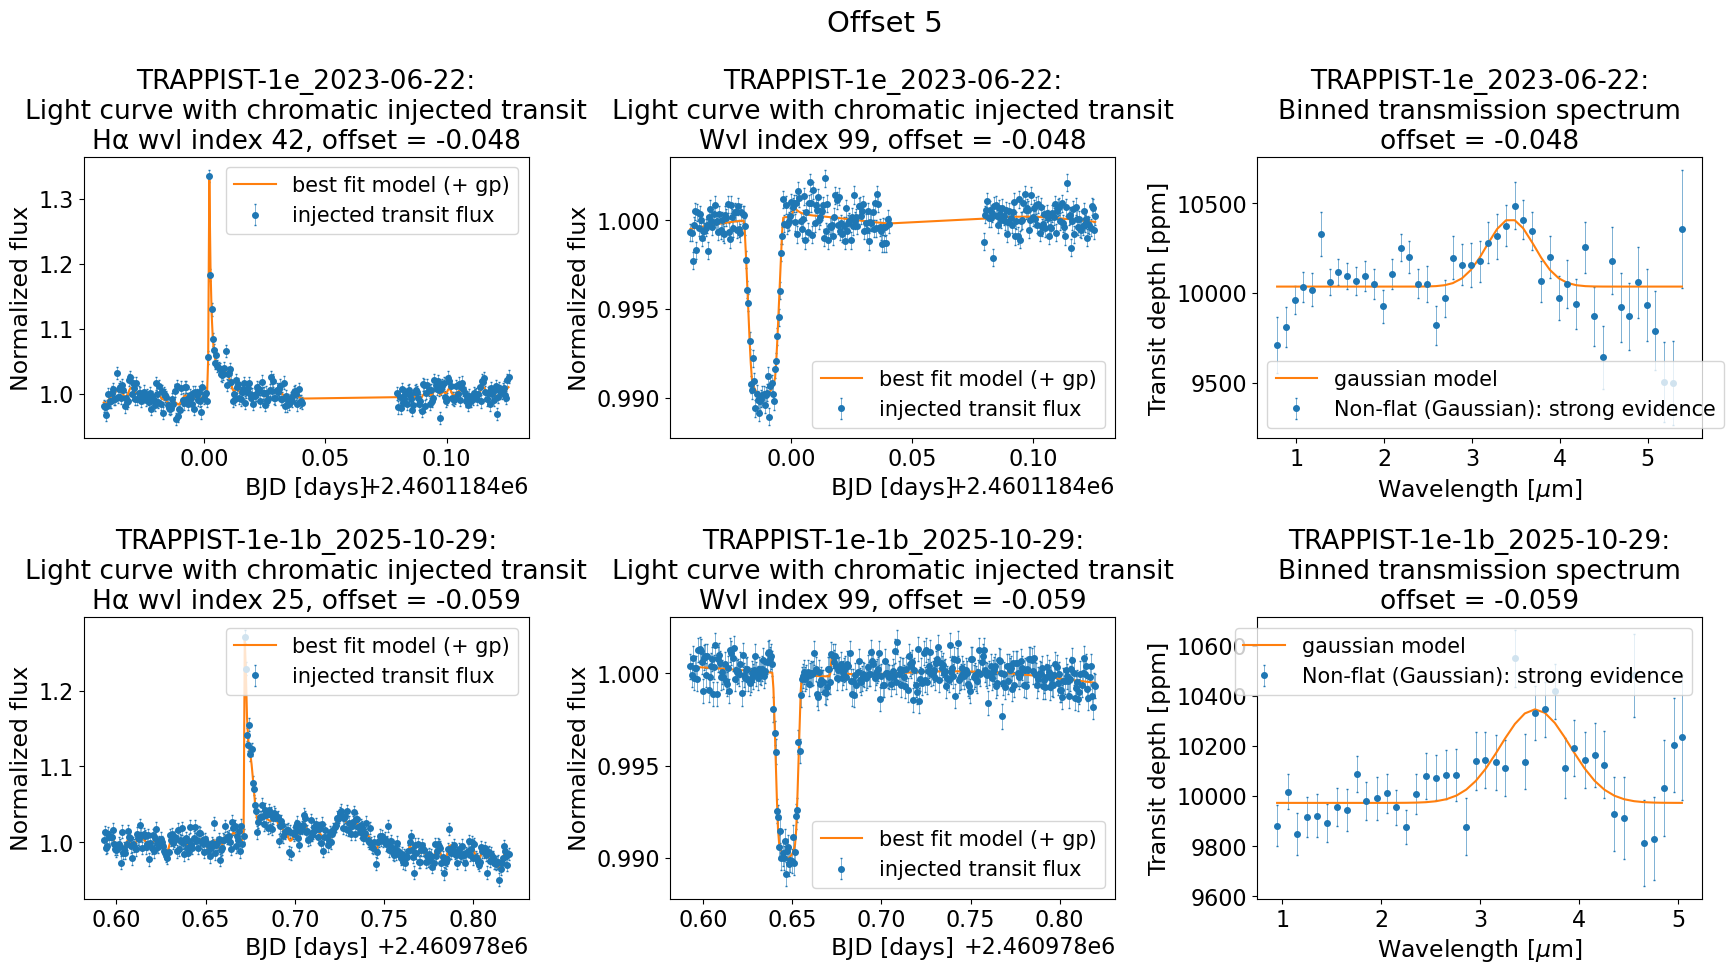

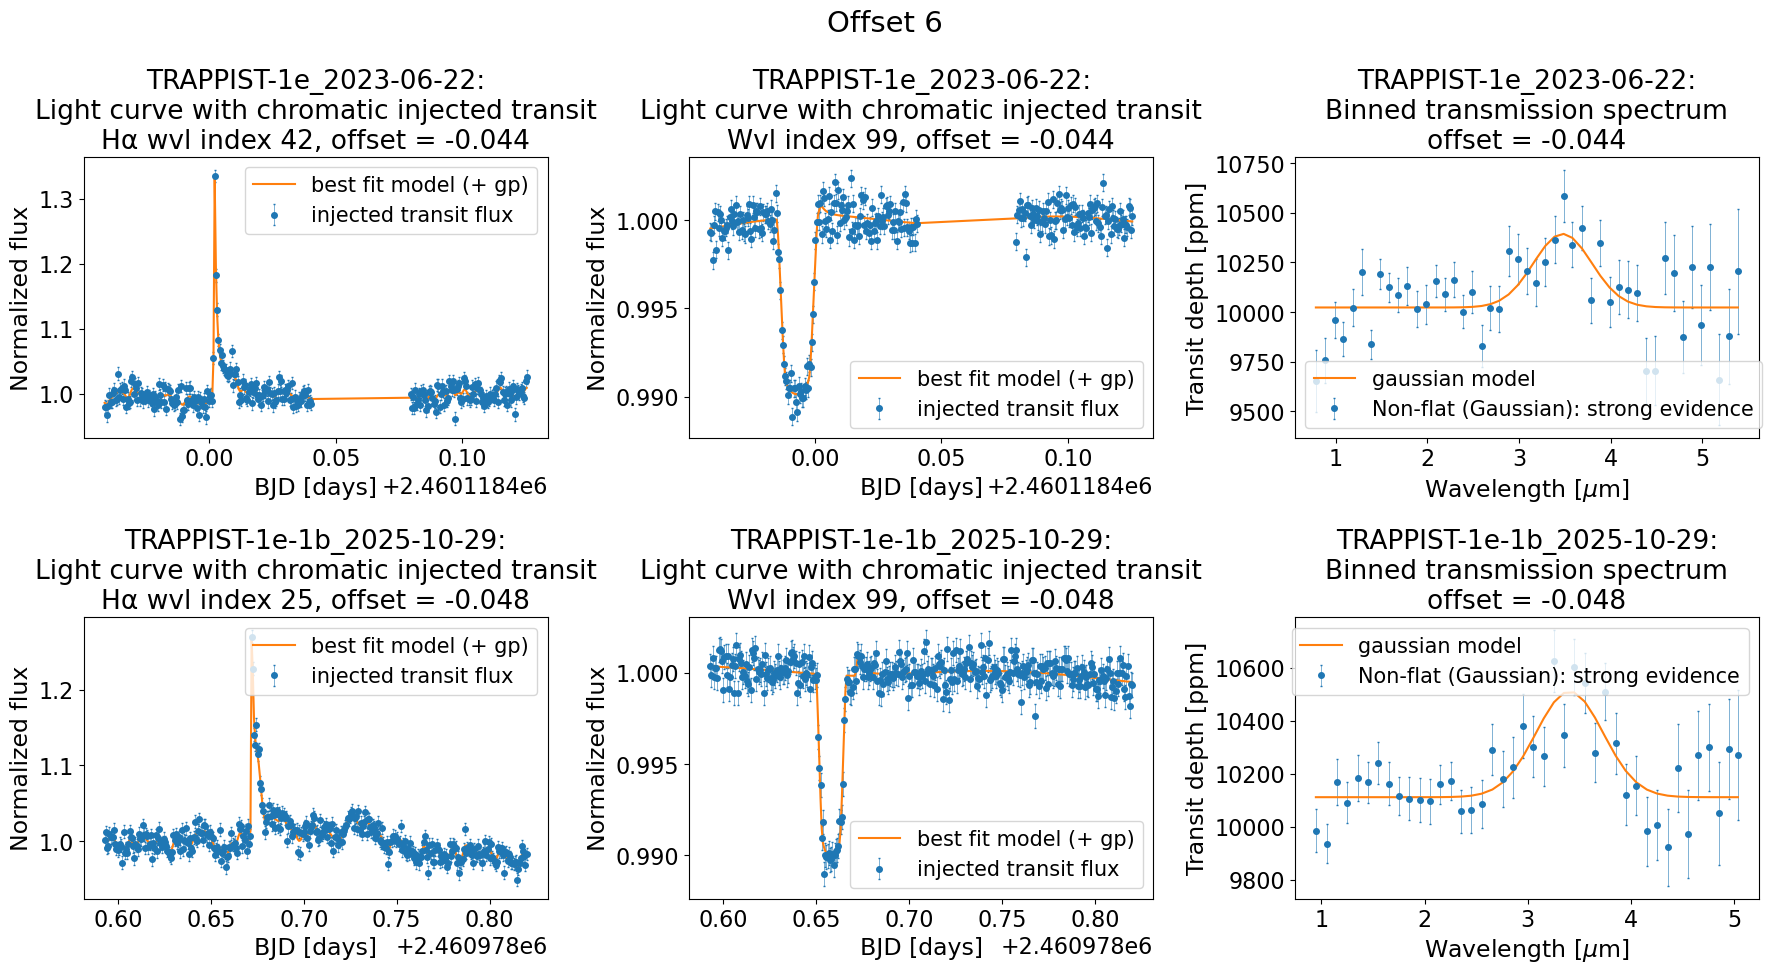

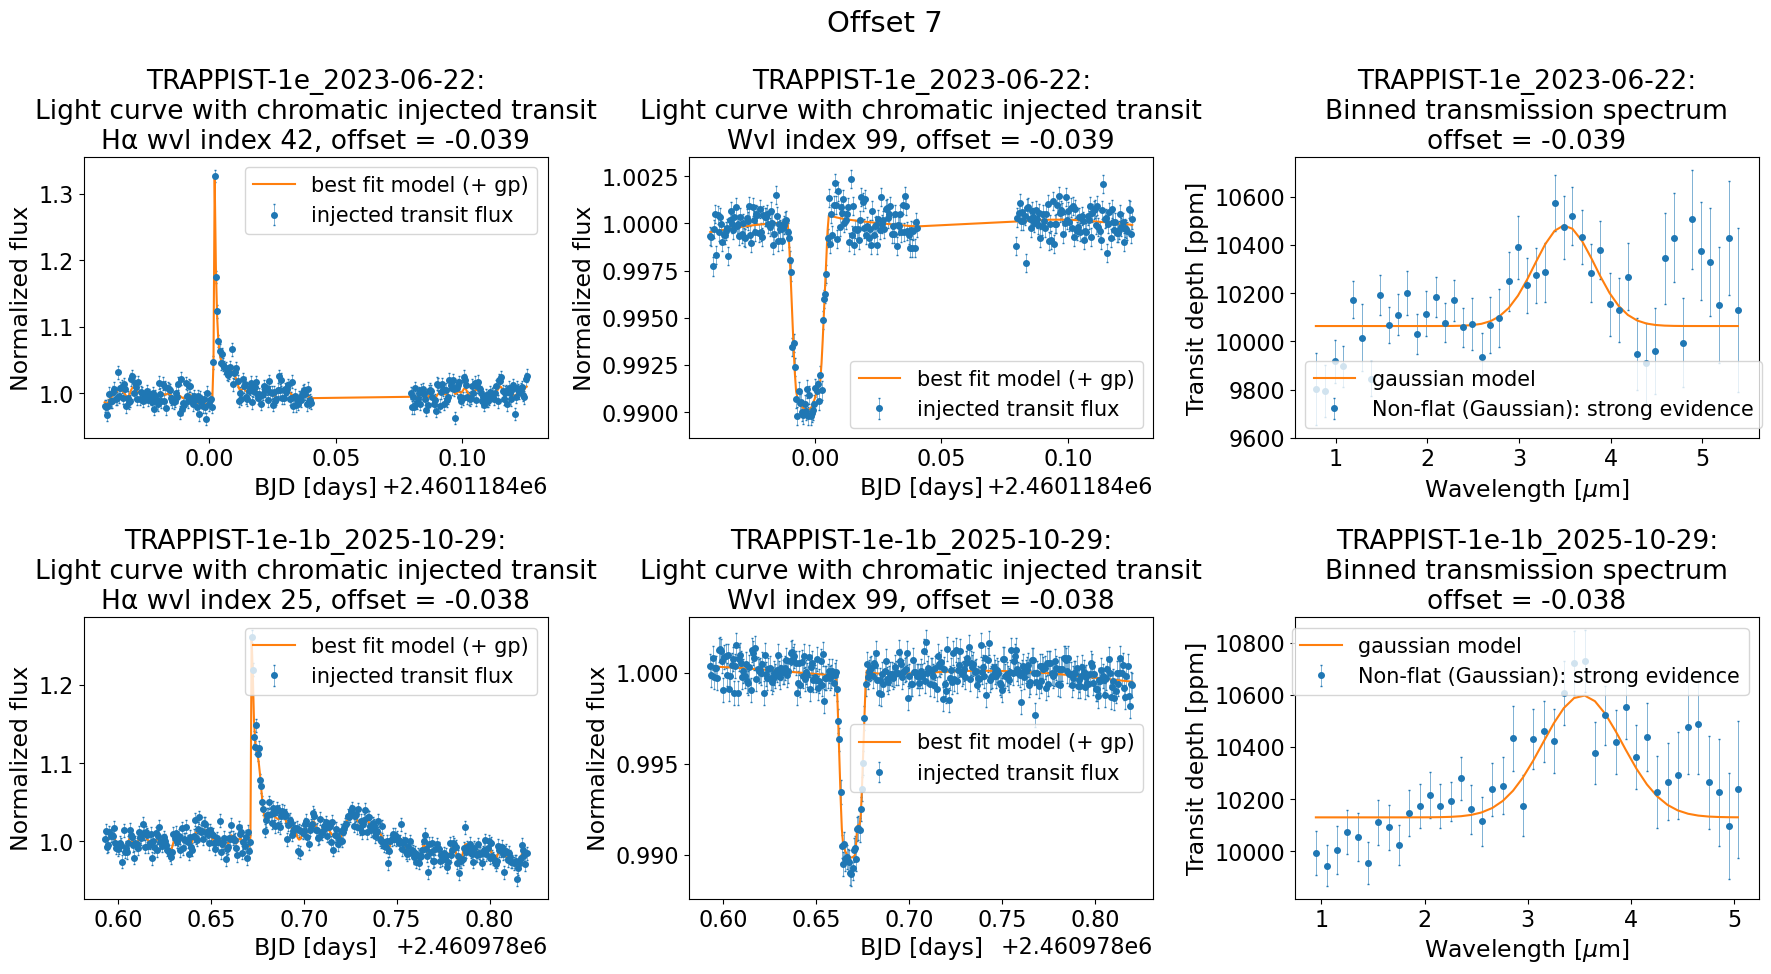

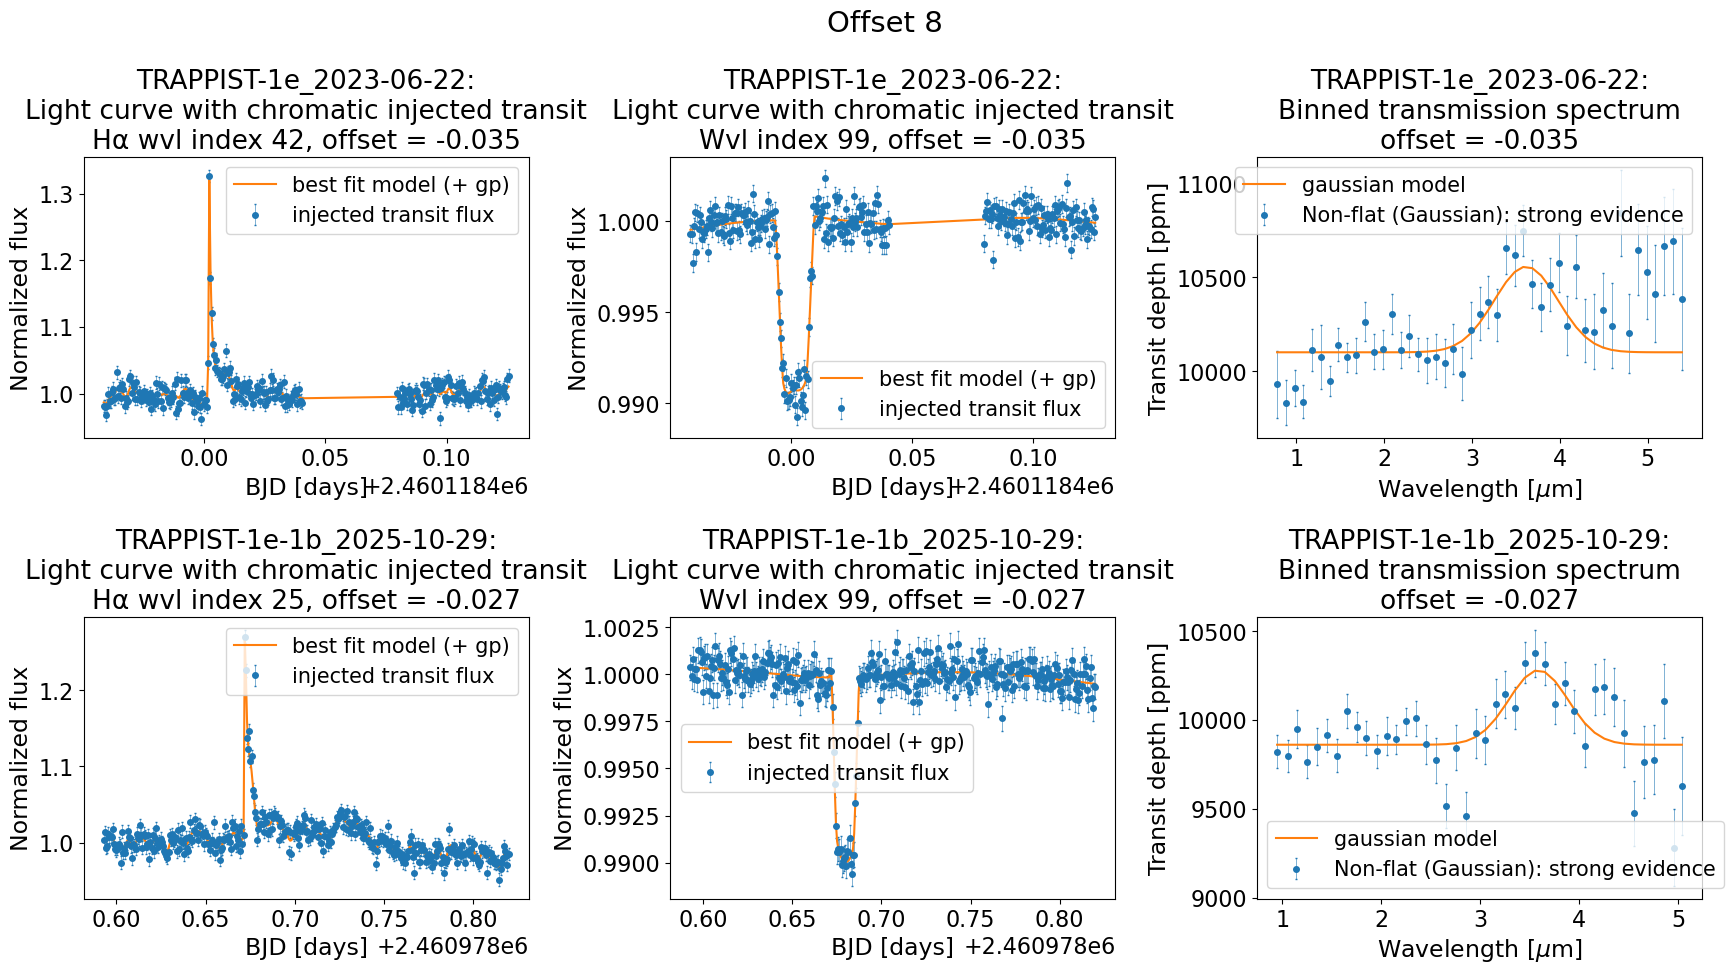

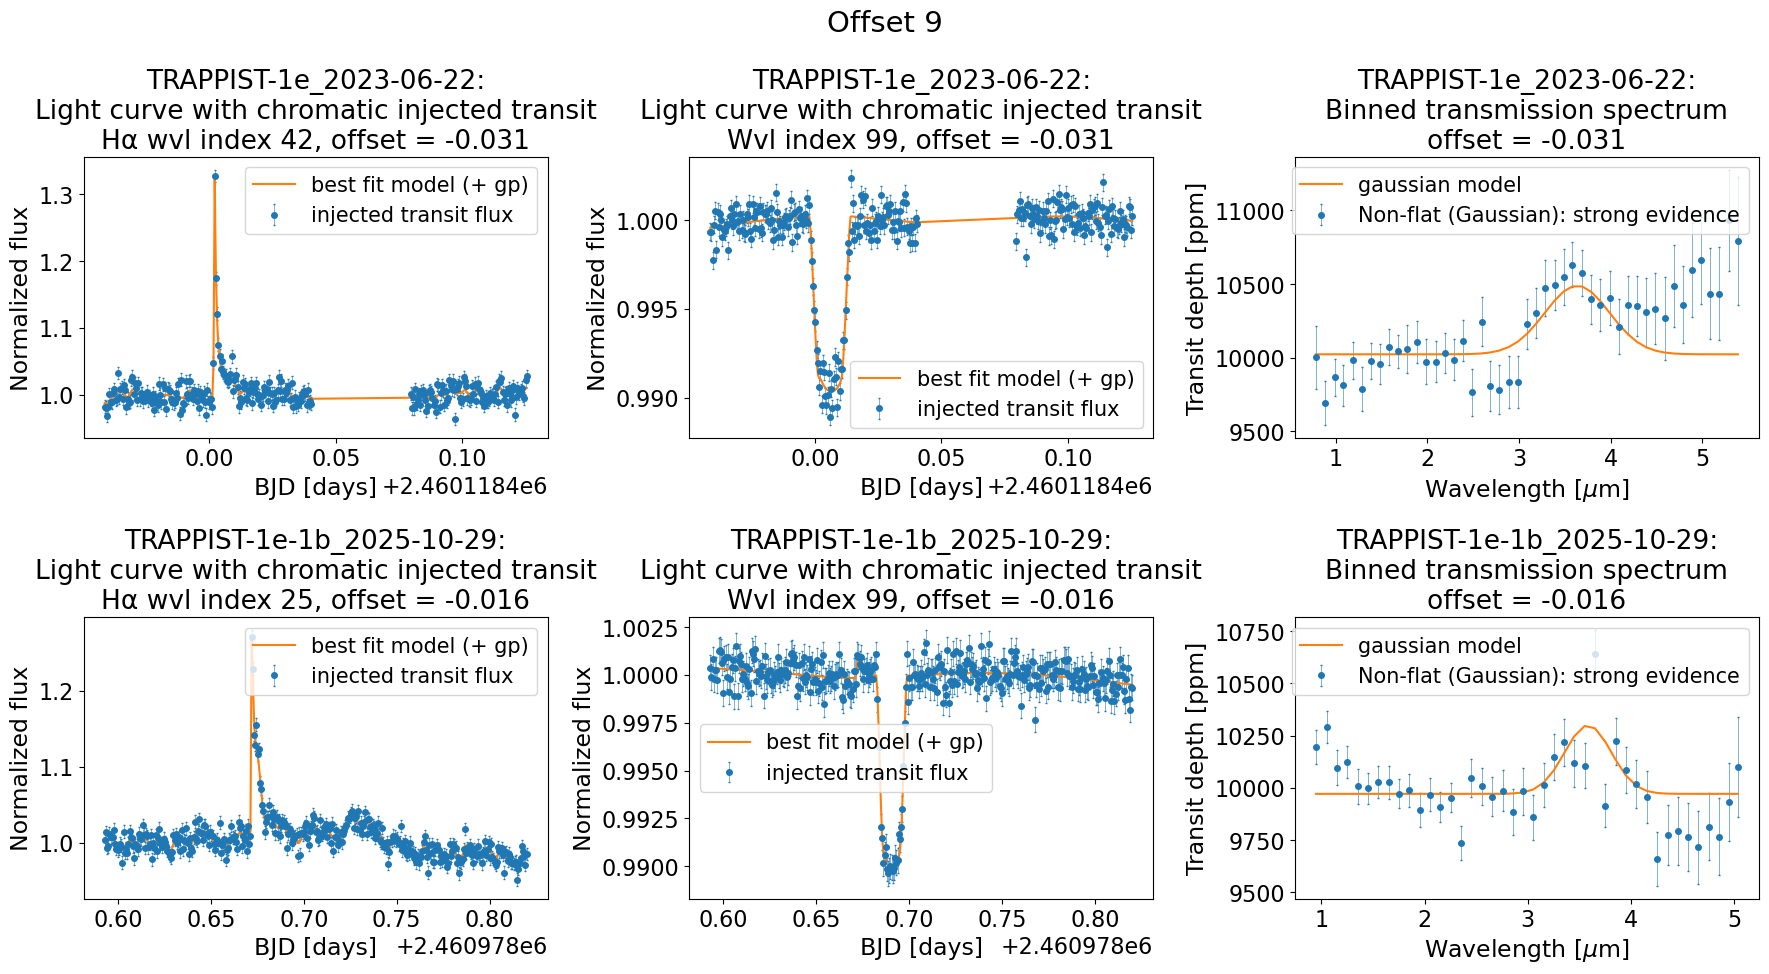

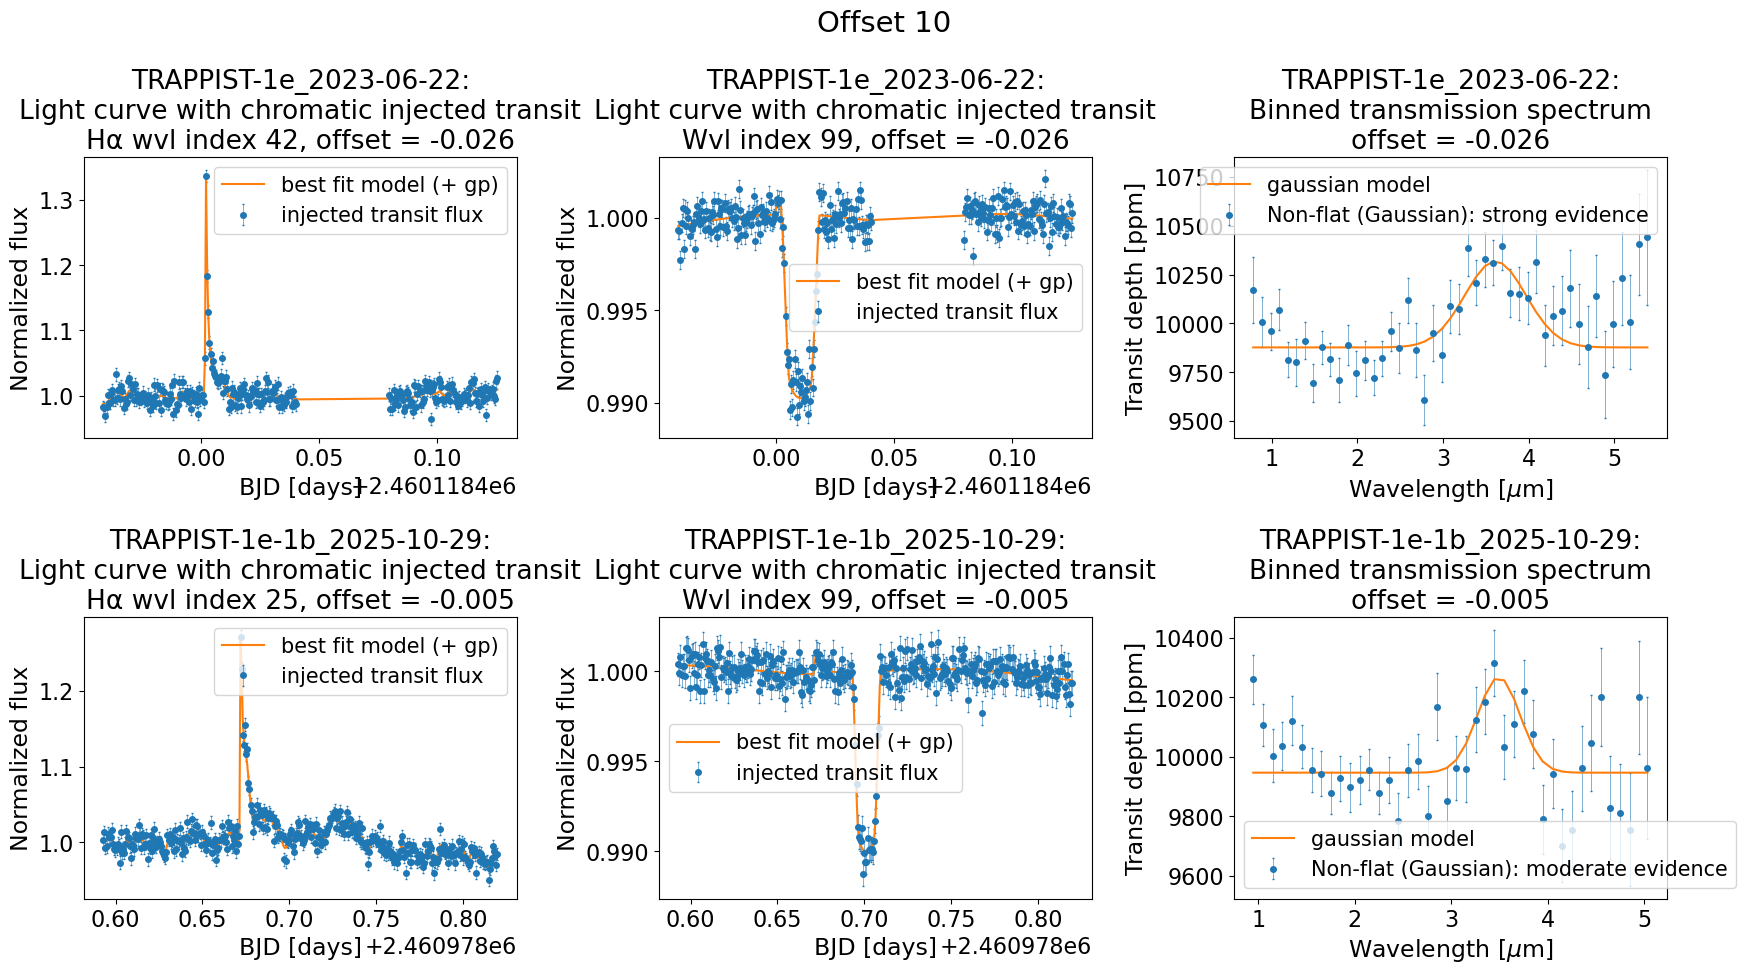

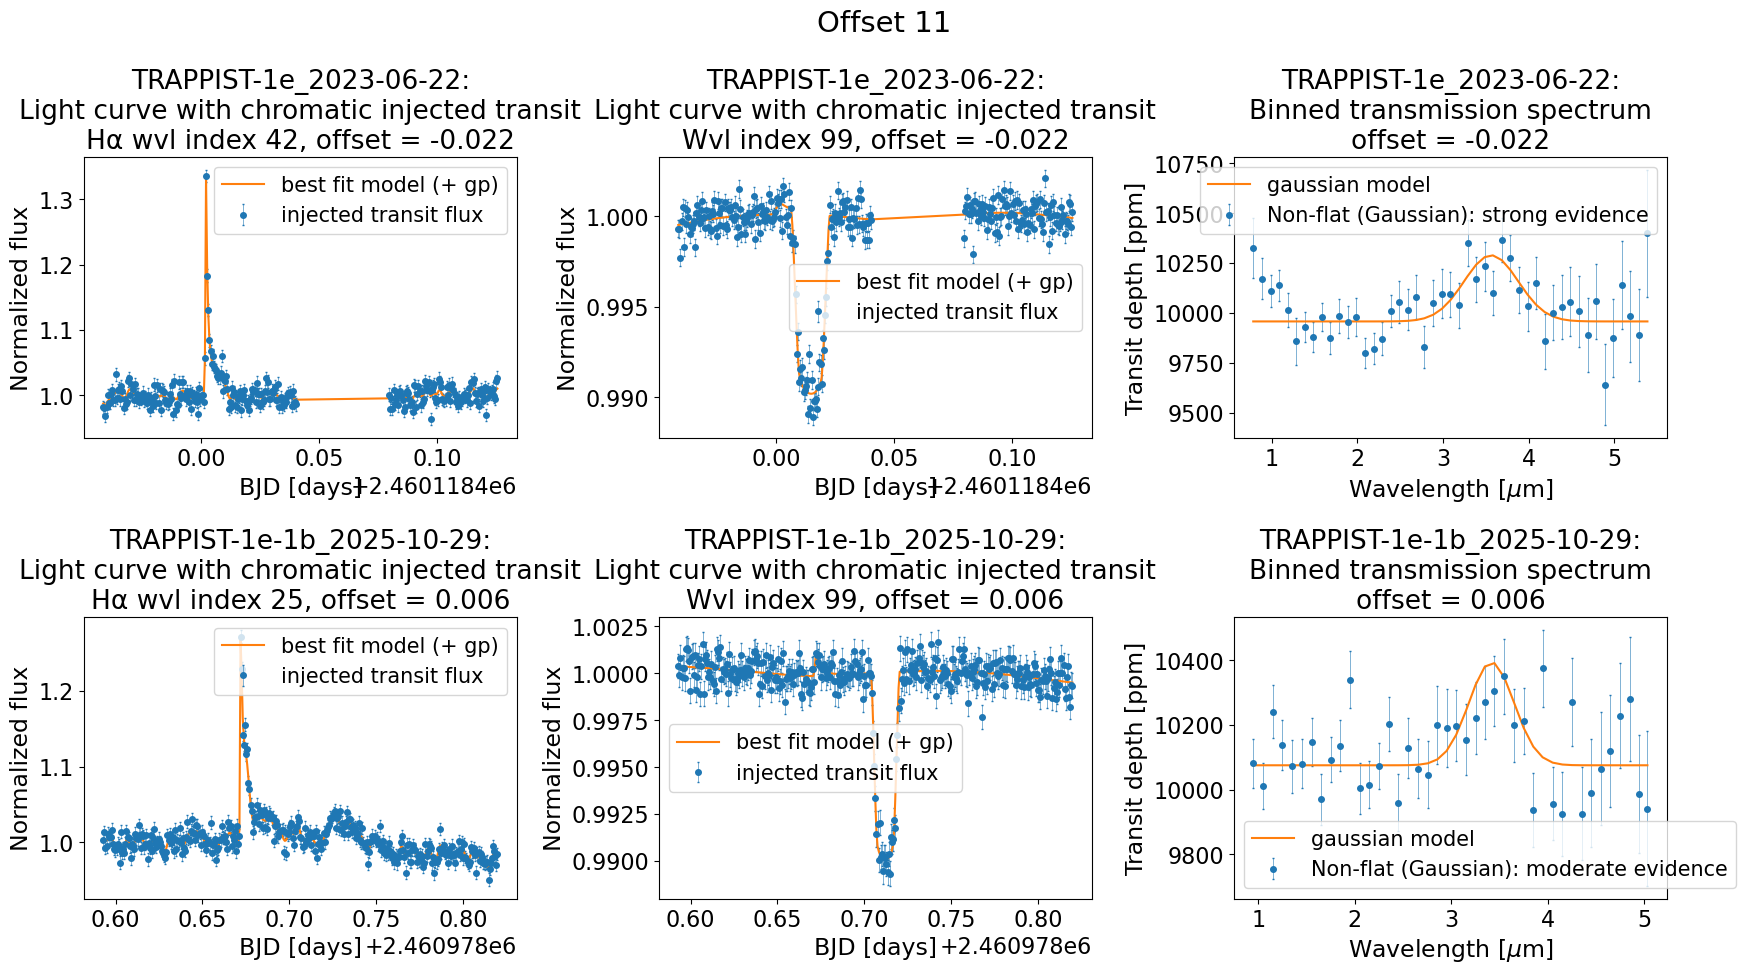

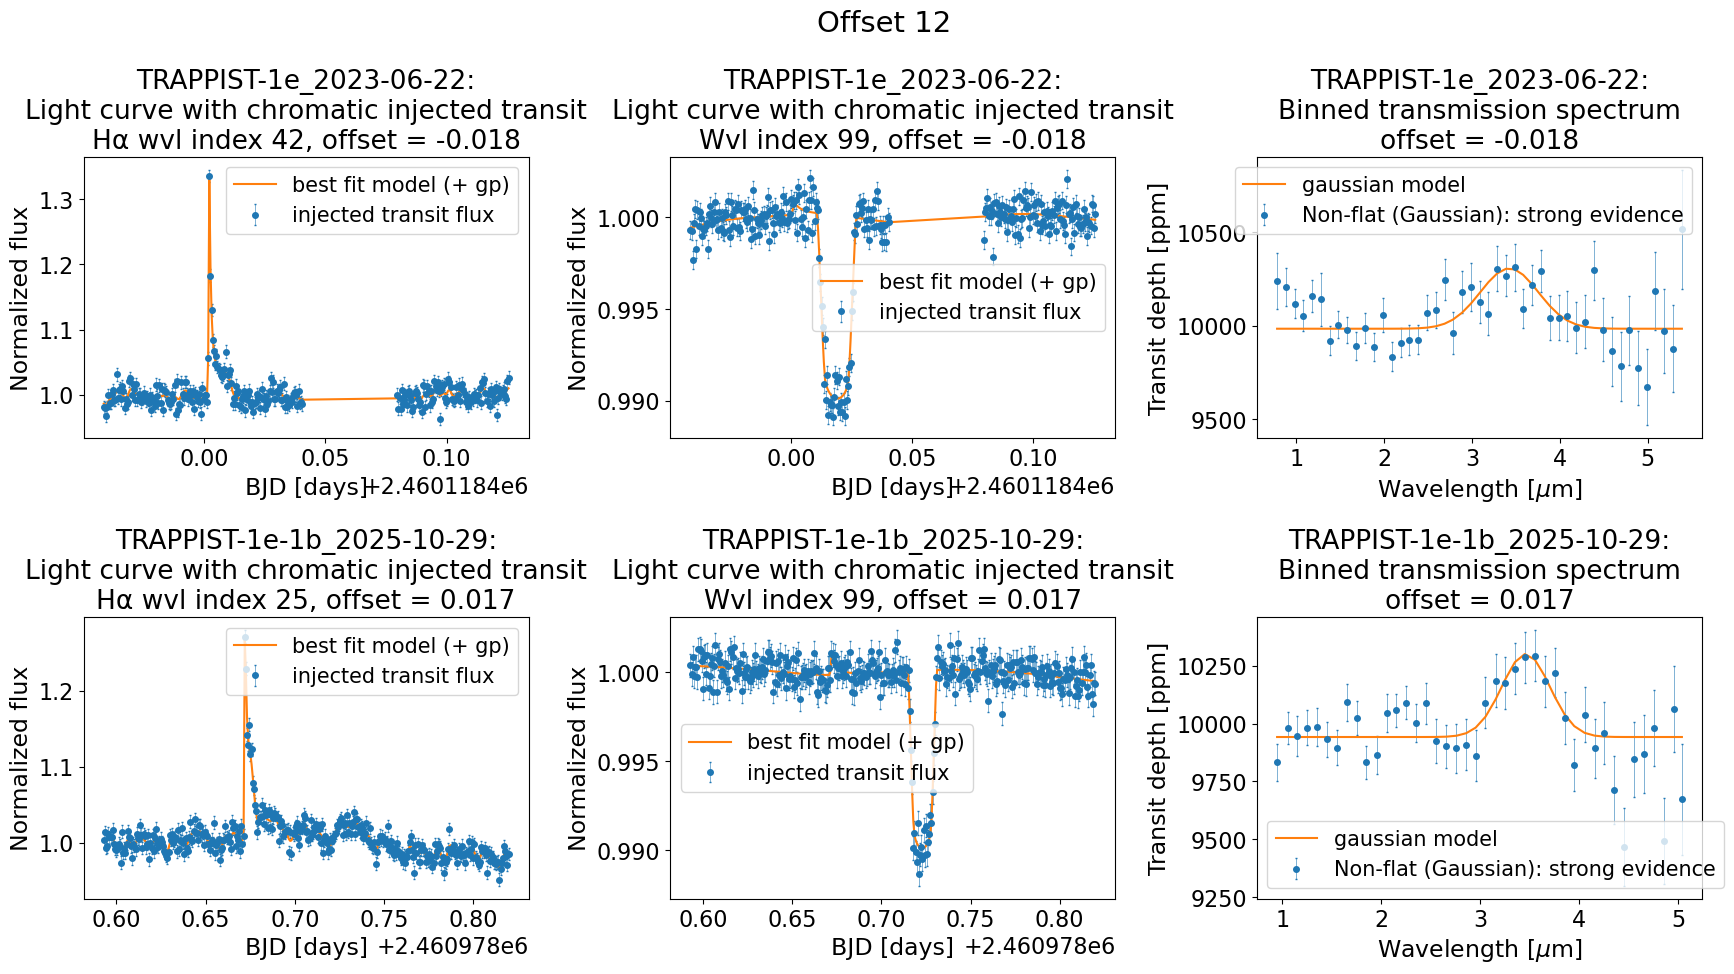

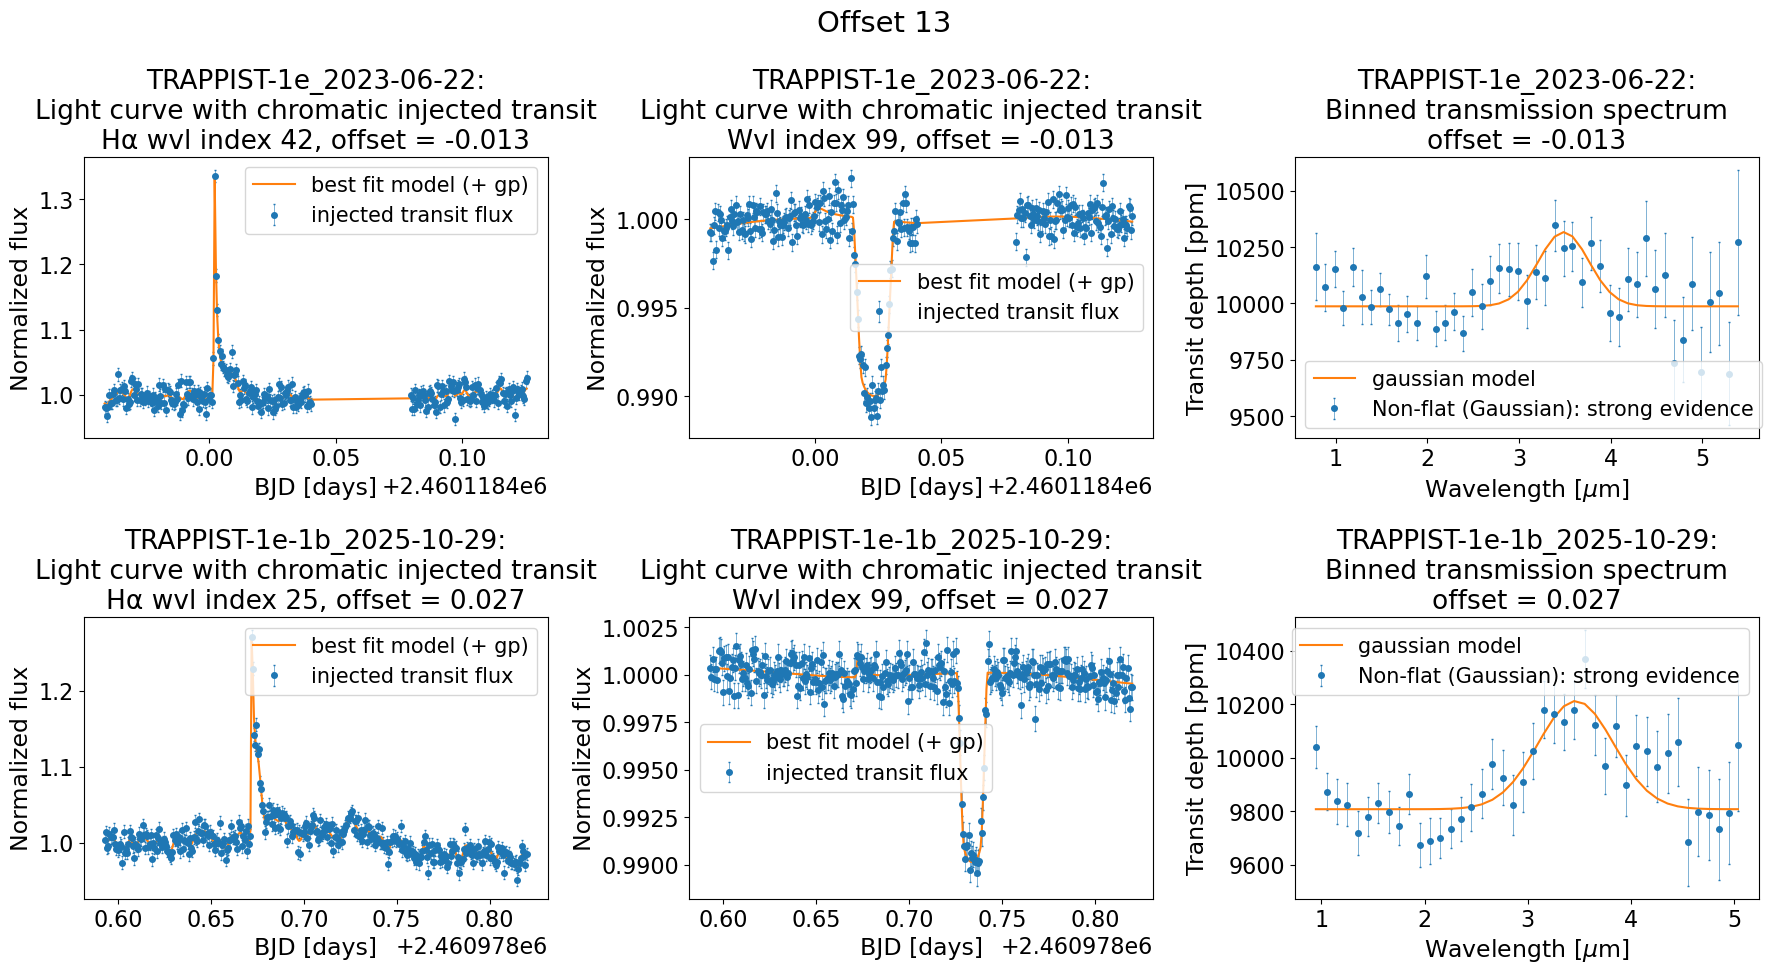

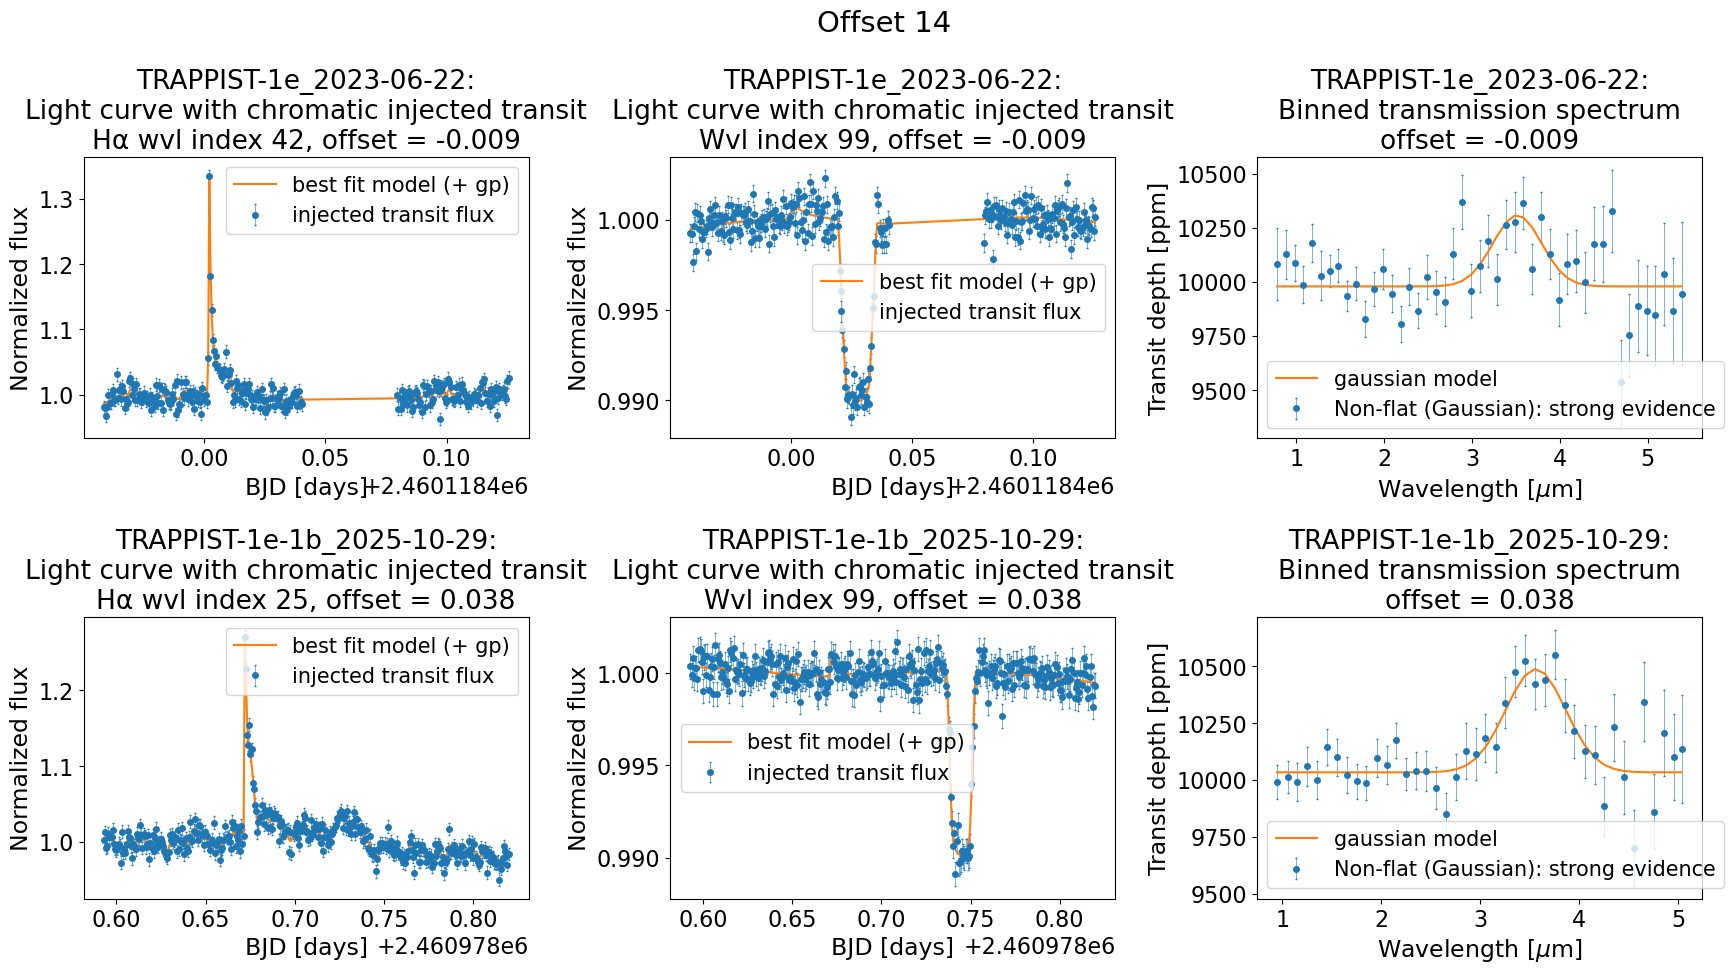

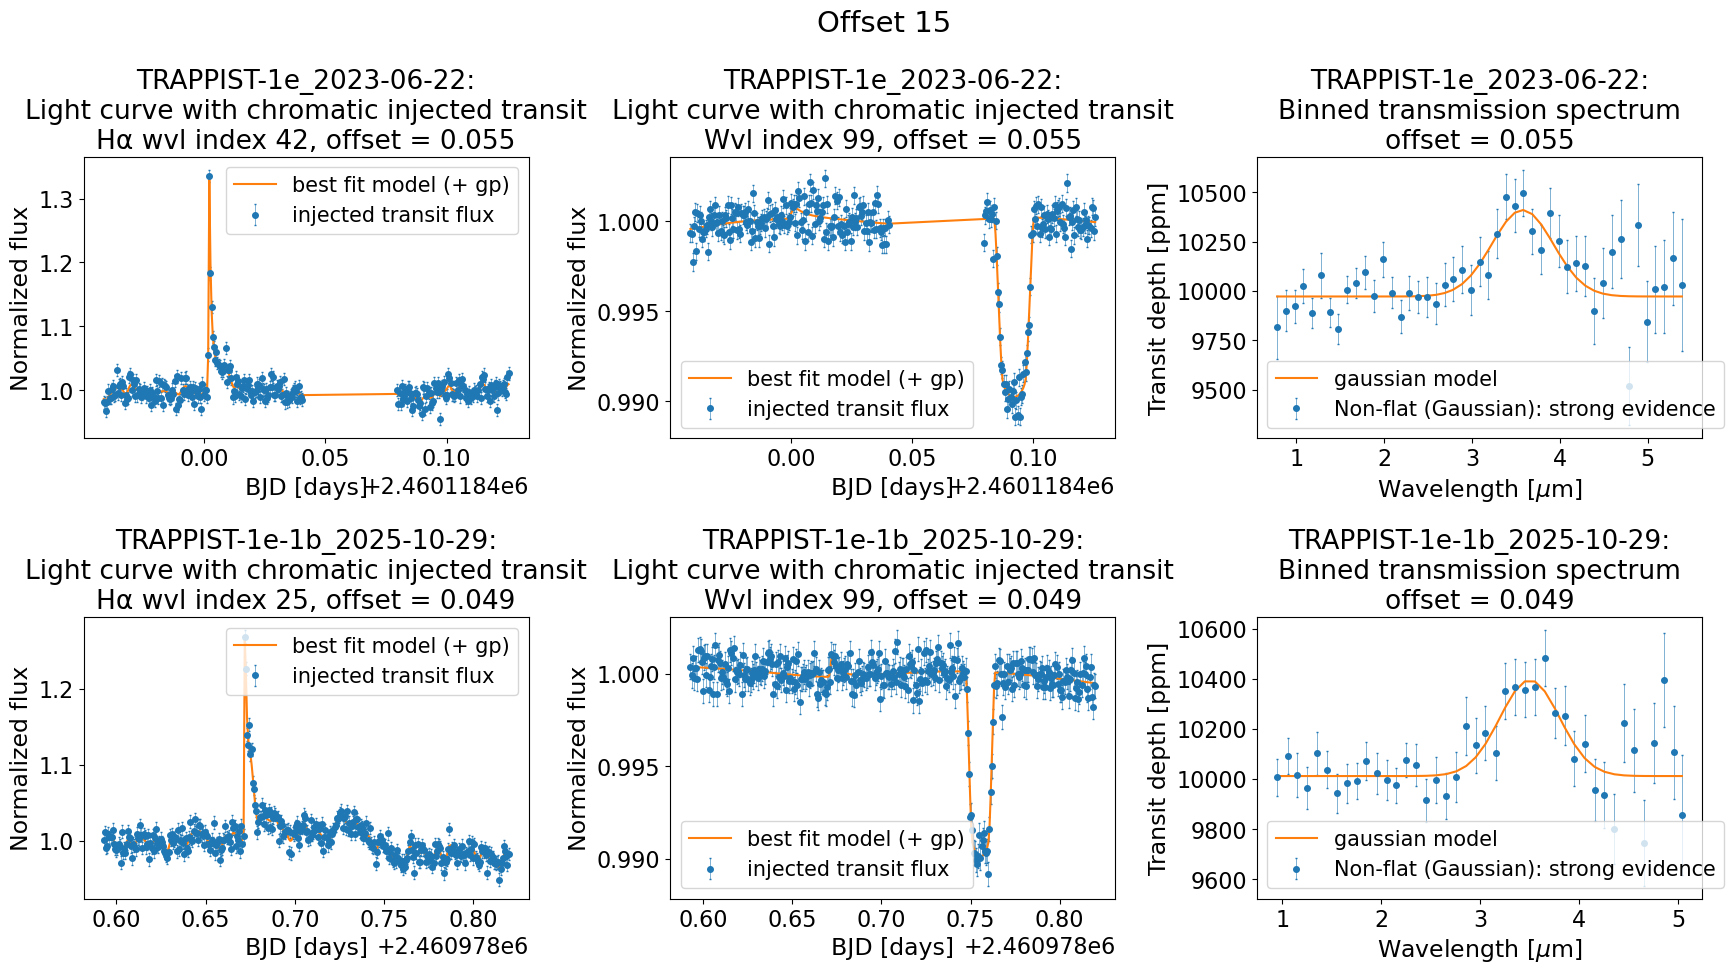

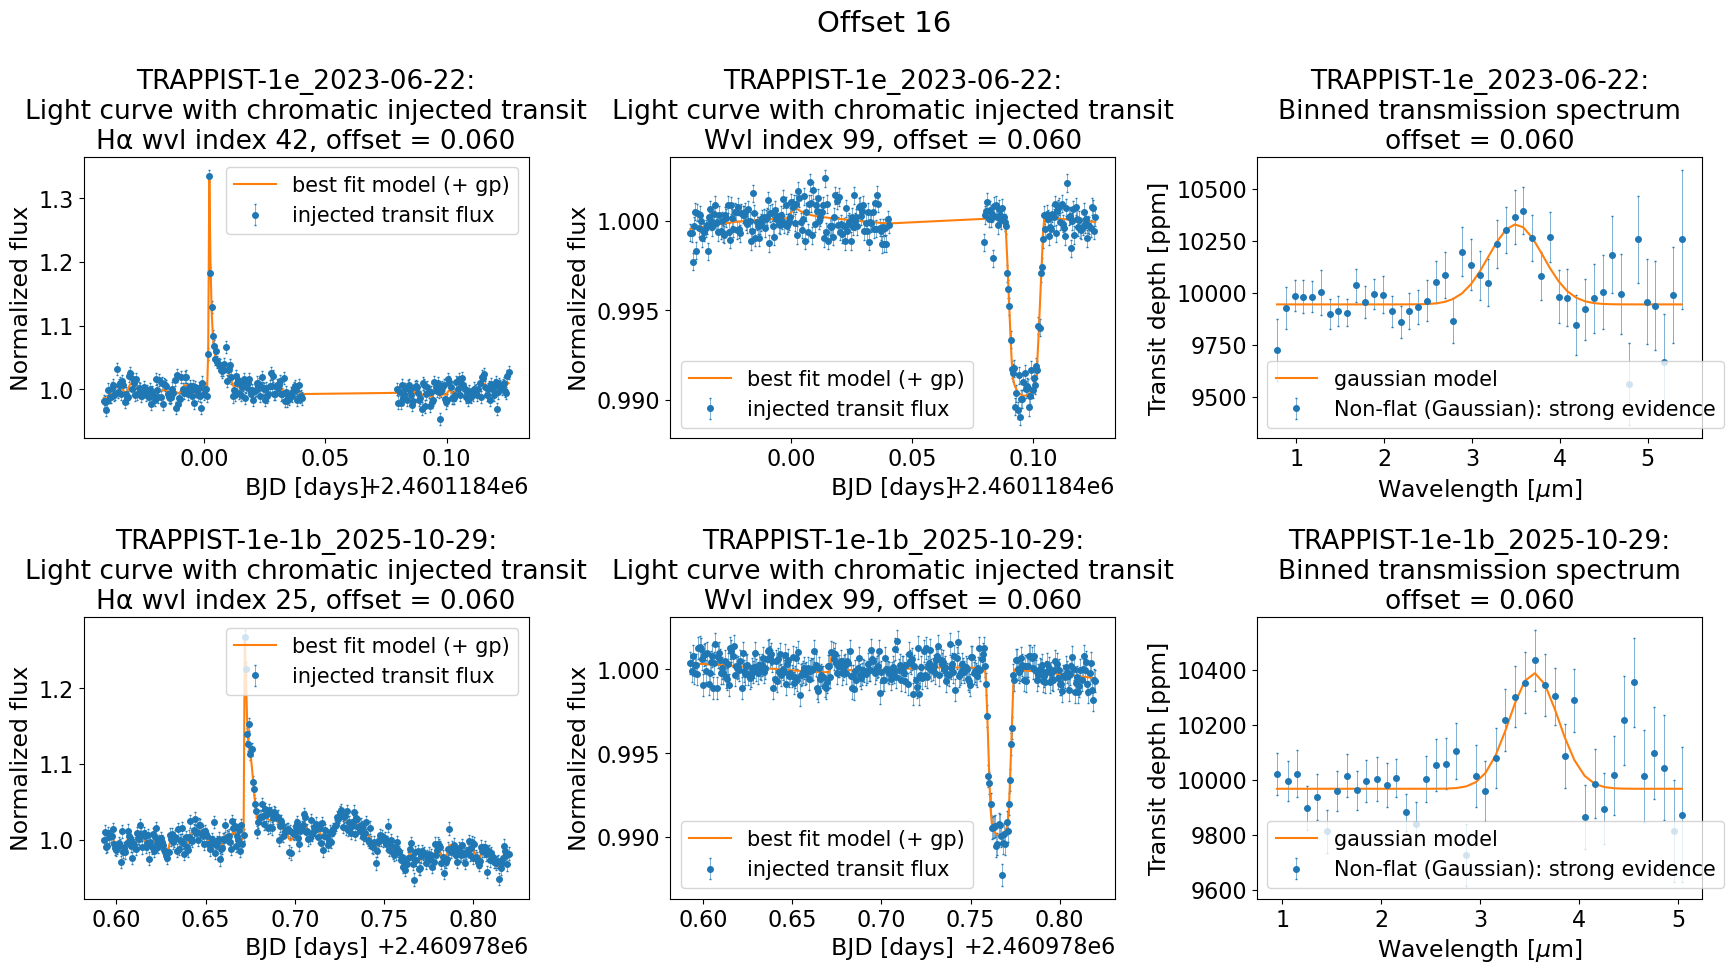

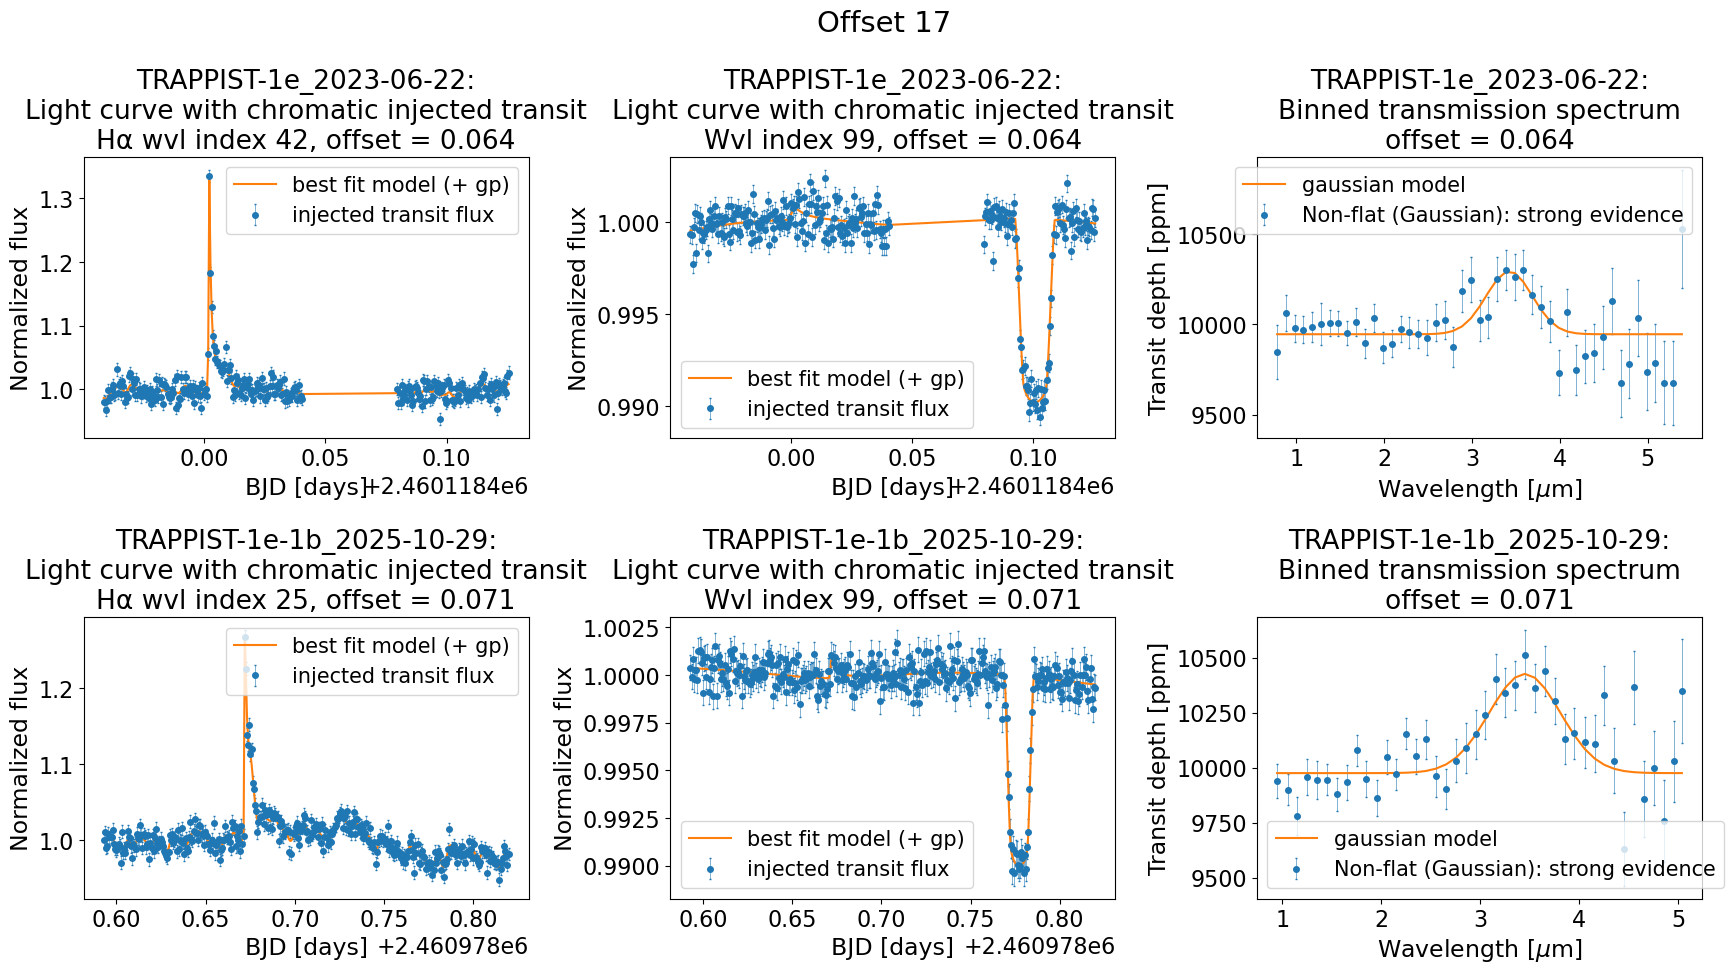

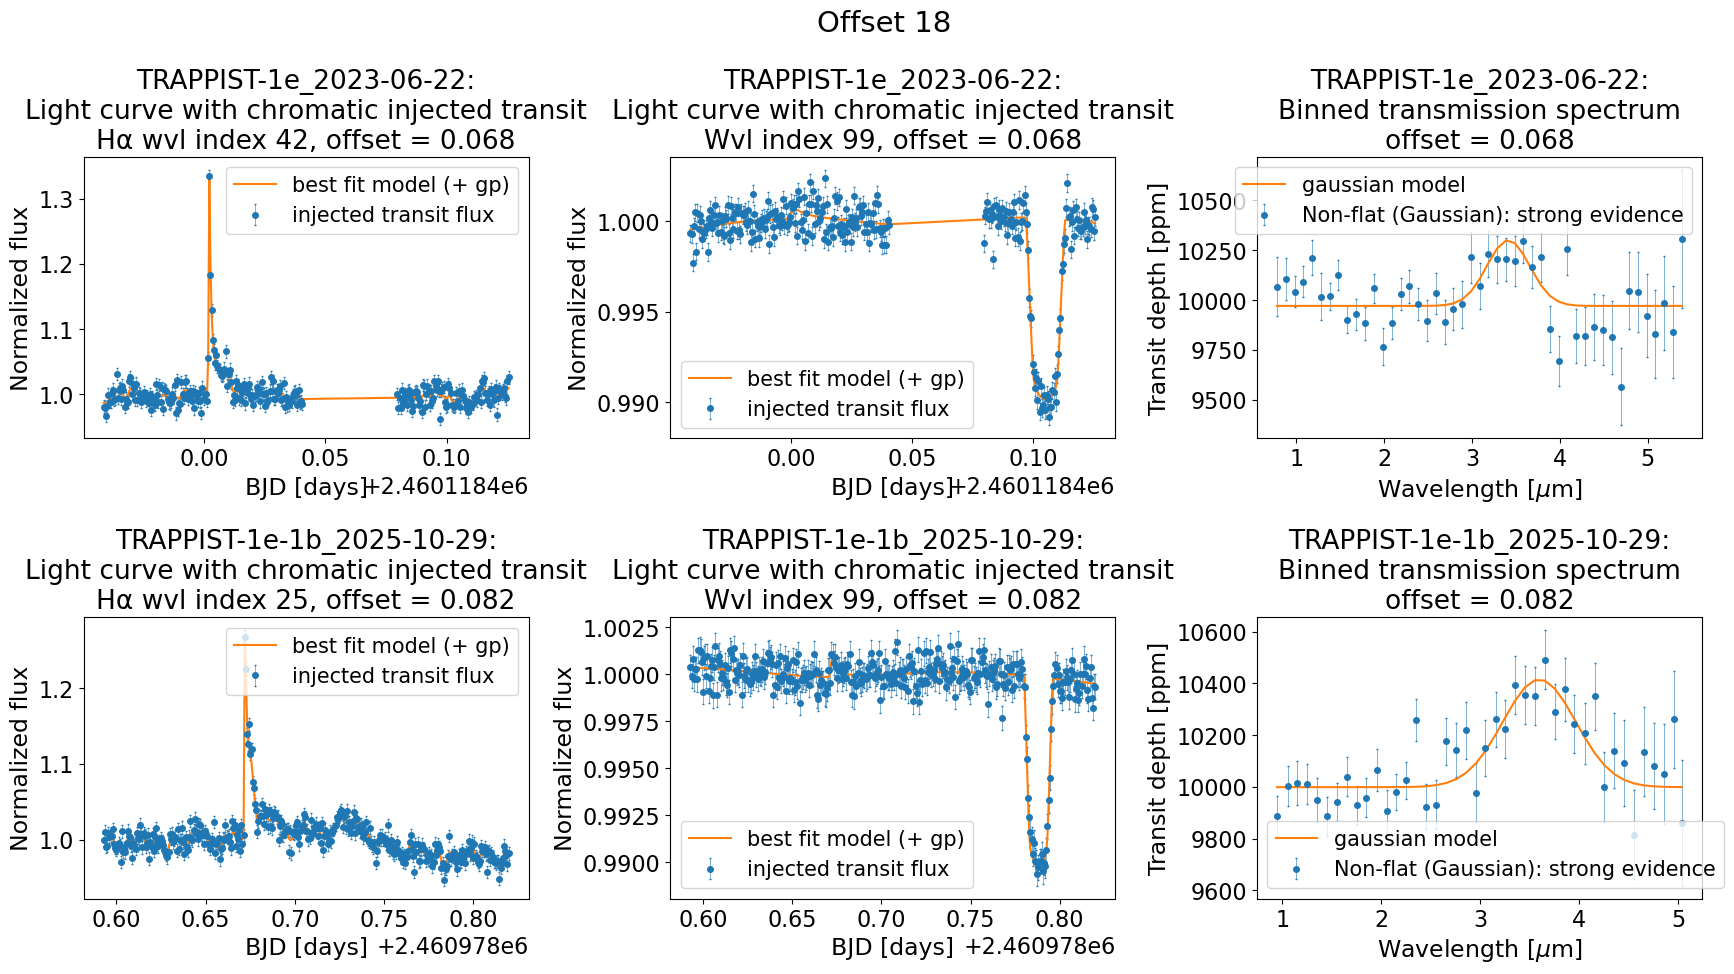

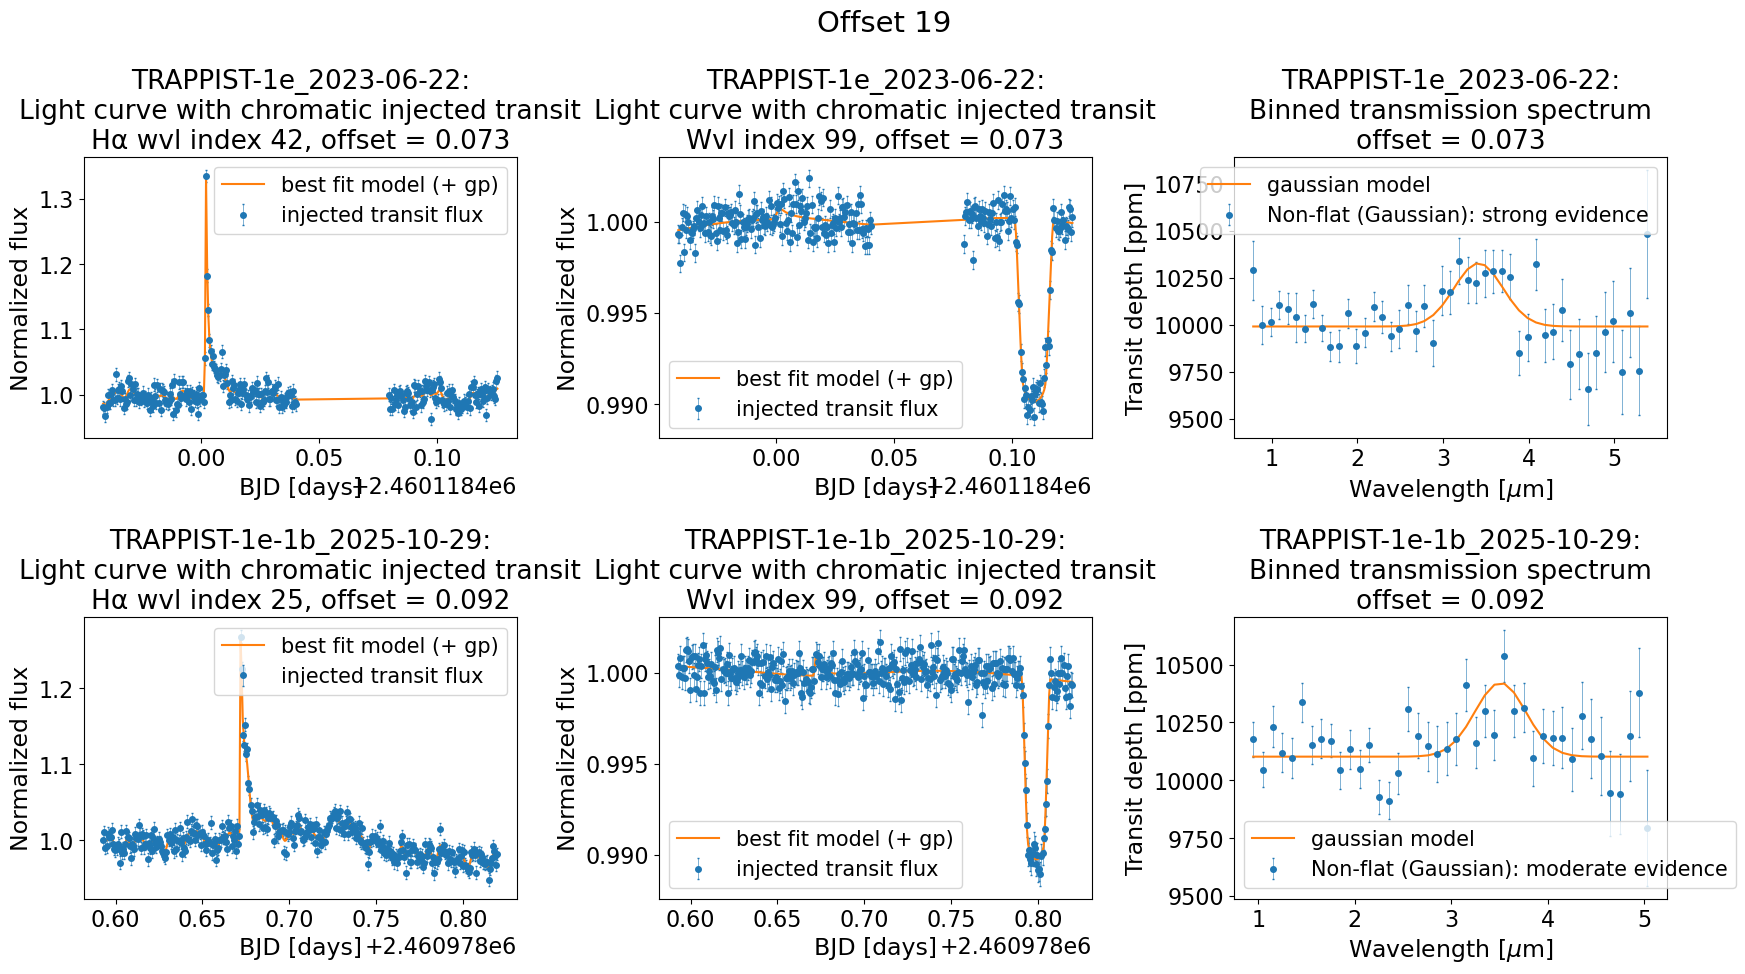

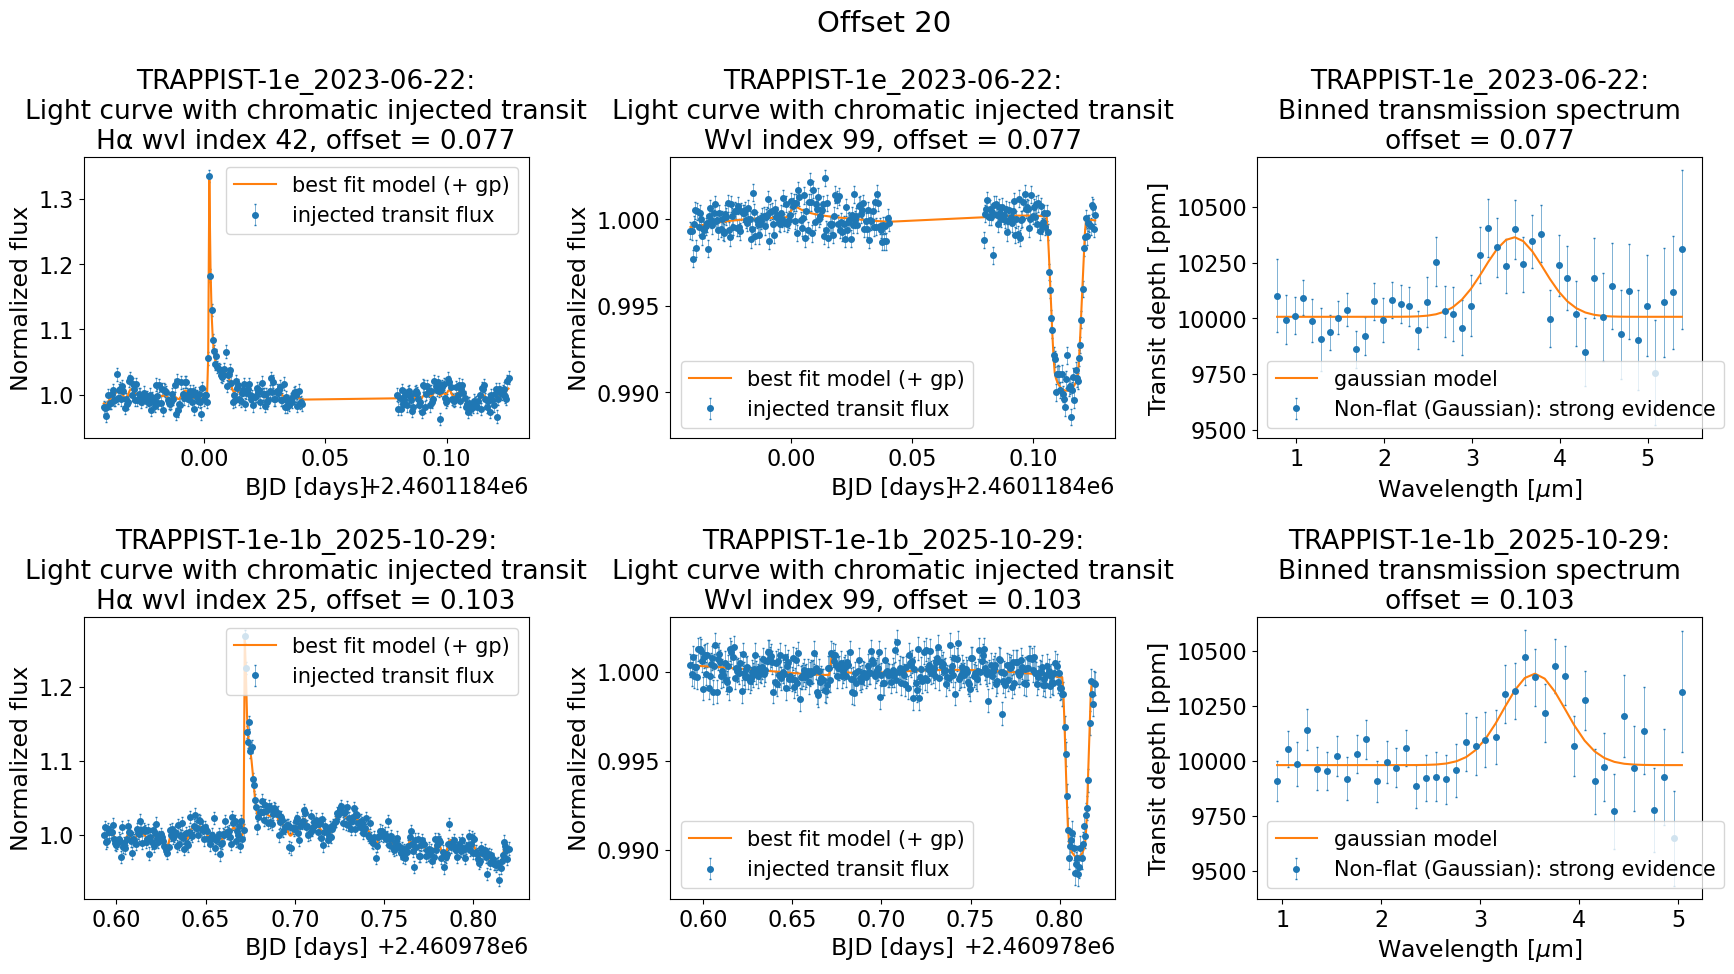

In [109]:
# Plot results in 3 subplots for each selected light curve and each offset
# Now organized by offset: each offset gets its own figure with both light curves

wvl_bin = 99 # Wavelength bin to plot

n_lc = len(data_dict_flares_new)
n_offsets = len(offset_list)

# Loop over offsets first, then light curves
for offset_idx, offset_val in enumerate(offset_list):
    fig, axes = pl.subplots(n_lc, 3, figsize=(18, 5 * n_lc))
    
    if n_lc == 1:
        axes = axes.reshape(1, 3)
    
    plot_idx = 0
    for lc_idx, (key, d) in enumerate(data_dict_flares_new.items()):

        halpha_wavelength = 0.6563 # microns
        halpha_bin = np.argmin(np.abs(d['wavelength'] - halpha_wavelength))

        # Mask out the transit for binned data
        it_index = d['it_index'].copy()
        padding = 7
        transit_indices = np.where(it_index == 1)[0]

        for t_idx in transit_indices:
            start = max(0, t_idx - padding)
            end = min(len(it_index), t_idx + padding + 1)
            it_index[start:t_idx] = 1
            it_index[t_idx + 1:end] = 1

        bjd_binned_masked = d['bjd_binned'][it_index == 0]
        flux_binned_masked = d['flux_binned'][it_index == 0]
        white_binned_masked = d['white_binned'][it_index == 0]
        white_err_binned_masked = d['white_err_binned'][it_index == 0]
        flux_err_binned_masked = d['flux_err_binned'][it_index == 0]

        if key == "TRAPPIST-1e-1b_2025-10-29":
            # Find transit groups to identify 3rd and 4th transits
            transit_groups = []
            current_group = []
            for i, is_transit in enumerate(it_index):
                if is_transit:
                    current_group.append(i)
                else:
                    if current_group:
                        transit_groups.append(current_group)
                        current_group = []
            if current_group:  # Add last group if it exists
                transit_groups.append(current_group)

            if len(transit_groups) >= 4:
                # Get indices after 3rd transit and before 4th transit
                end_3rd_transit = transit_groups[2][-1]
                start_4th_transit = transit_groups[3][0]
                
                # Create mask for data between 3rd and 4th transits
                between_mask = np.arange(len(d['bjd_binned']))
                between_mask = (between_mask > end_3rd_transit) & (between_mask < start_4th_transit)
                
                # Apply both out-of-transit mask and between-transits mask
                final_mask = (it_index == 0) & between_mask
                
                bjd_binned_masked = d['bjd_binned'][final_mask]
                flux_binned_masked = d['flux_binned'][final_mask]
                flux_err_binned_masked = d['flux_err_binned'][final_mask]
                white_binned_masked = d['white_binned'][final_mask]
                white_err_binned_masked = d['white_err_binned'][final_mask]

        j = offset_lists[key][offset_idx]
        
        output_filename = f'outputs/mcmc_results_{key}_{j:.5f}_gp_feature.txt'

        # Load existing results
        data = np.loadtxt(output_filename, delimiter=',', skiprows=1)
        rp_fits = data[:, 0]
        rp_errs = data[:, 1]
        slope_fits = data[:, 2]
        slope_errs = data[:, 3]
        intercept_fits = data[:, 4]
        intercept_errs = data[:, 5]
        tpeak_fits = data[:, 6]
        tpeak_errs = data[:, 7]
        fwhm_fits = data[:, 8]
        fwhm_errs = data[:, 9]
        ampl_fits = data[:, 10]
        ampl_errs = data[:, 11]
        sigma_fits = data[:, 12]
        sigma_errs = data[:, 13]
        l_fits = data[:, 14]
        l_errs = data[:, 15]

        ax1, ax2, ax3 = axes[plot_idx]
        
        params = batman.TransitParams()
        params.t0 = np.mean(bjd_binned_masked)+j    #time of inferior conjunction
        params.per = 1.                             #orbital period
        params.a = 15.                              #semi-major axis (in units of stellar radii)
        params.inc = 87.                            #orbital inclination (in degrees)
        params.ecc = 0.                             #eccentricity
        params.w = 90.                              #longitude of periastron (in degrees)
        params.u = [0.1, 0.3]                       #limb darkening coefficients [u1, u2]
        params.limb_dark = "quadratic"              #limb darkening model

        # -----------------------------------------------
        # Inject CHROMATIC transit depths
        # -----------------------------------------------

        # Define chromatic feature
        Rp0 = 0.1            # baseline radius ratio
        A = 0.002            # amplitude of spectral feature  
        lambda0 = 3.5        # center of feature [micron]
        sigma_lambda = 0.3   # width of Gaussian [micron]

        wavelengths = d['wavelength']  # array of wavelength bins

        # Compute chromatic Rp(λ)
        Rp_lambda = Rp0 + A * np.exp(-0.5 * ((wavelengths - lambda0) / sigma_lambda)**2)

        # Inject chromatic transit model
        flux_binned_masked_injected = np.zeros_like(flux_binned_masked)

        batman_models = []
        for i in range(flux_binned_masked.shape[1]):
            # update transit parameters for this wavelength
            params.rp = Rp_lambda[i]

            m = batman.TransitModel(params, bjd_binned_masked)
            chromatic_flux = m.light_curve(params)

            batman_models.append(chromatic_flux)

            baseline_mask = (chromatic_flux == 1.0)

            # injection: remove original baseline, add chromatic transit model
            flux_binned_masked_injected[:, i] = (flux_binned_masked[:, i] - np.median(flux_binned_masked[baseline_mask, i]) + chromatic_flux)

        # Light curve with chromatic injected transit at h-alpha bin
        ax1.errorbar(bjd_binned_masked, flux_binned_masked_injected[:, halpha_bin], yerr=flux_err_binned_masked[:, halpha_bin], 
                     fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'injected transit flux')
        
        # Add best-fit model for h-alpha bin
        
        # Transit model
        transit_flux = batman_models[halpha_bin]    
        # Linear systematics
        linear_systematics_halpha = slope_fits[halpha_bin] * (bjd_binned_masked - bjd_binned_masked[0]) + intercept_fits[halpha_bin]
        # Flare model
        flare_halpha = flare_model(bjd_binned_masked, tpeak_fits[halpha_bin], fwhm_fits[halpha_bin], ampl_fits[halpha_bin])
        # Combine all components
        best_fit_model_halpha = transit_flux + linear_systematics_halpha + flare_halpha
        
        gp_halpha = build_gp(sigma_fits[halpha_bin], l_fits[halpha_bin], bjd_binned_masked , flux_err_binned_masked[:, halpha_bin])

        residuals_halpha = flux_binned_masked_injected[:, halpha_bin] - best_fit_model_halpha
        gp_mean_halpha, gp_cov_halpha = gp_halpha.predict(residuals_halpha, bjd_binned_masked, return_cov=True)
        full_model_halpha = best_fit_model_halpha + gp_mean_halpha
        
        ax1.plot(bjd_binned_masked, full_model_halpha, label=f'best fit model (+ gp)')  
        #ax1.plot(bjd_binned_masked, best_fit_model_halpha, label=f'best fit model')
        ax1.set_xlabel('BJD [days]')
        ax1.set_ylabel('Normalized flux')
        ax1.set_title(f'{key}:\nLight curve with chromatic injected transit\nHα wvl index {halpha_bin}, offset = {j:.3f}')
        ax1.legend()


        # Light curve with chromatic injected transit at wvl_bin
        ax2.errorbar(bjd_binned_masked, flux_binned_masked_injected[:, wvl_bin], yerr=flux_err_binned_masked[:, wvl_bin], 
                     fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'injected transit flux')
        
        # Add best-fit model for wvl_bin
        best_fit_model_wvl = (batman_models[wvl_bin] +
                          slope_fits[wvl_bin] * (bjd_binned_masked - bjd_binned_masked[0]) + intercept_fits[wvl_bin] +
                          flare_model(bjd_binned_masked, tpeak_fits[wvl_bin], fwhm_fits[wvl_bin], ampl_fits[wvl_bin]))
        
        gp_wvl = build_gp(sigma_fits[wvl_bin], l_fits[wvl_bin], bjd_binned_masked , flux_err_binned_masked[:, wvl_bin])

        residuals_wvl = flux_binned_masked_injected[:, wvl_bin] - best_fit_model_wvl
        gp_mean_wvl, gp_cov_wvl = gp_wvl.predict(residuals_wvl, bjd_binned_masked, return_cov=True)
        full_model_wvl = best_fit_model_wvl + gp_mean_wvl
 
        ax2.plot(bjd_binned_masked, full_model_wvl, label=f'best fit model (+ gp)')  
        #ax2.plot(bjd_binned_masked, best_fit_model_wvl, label=f'best fit model')

        ax2.set_xlabel('BJD [days]')
        ax2.set_ylabel('Normalized flux')
        ax2.set_title(f'{key}:\nLight curve with chromatic injected transit\nWvl index {wvl_bin}, offset = {j:.3f}')
        ax2.legend()

        # Transmission spectrum
        wavelength = d['wavelength']
        mask = ~np.isnan(wavelength)
        wl_masked = wavelength[mask]
        rp_masked = rp_fits[mask]
        rp_err_masked = rp_errs[mask]

        # Slice off edges to avoid noisy wvl bins
        slice_start = 55
        slice_end = len(wl_masked) - 40

        wl_masked = wl_masked[slice_start:slice_end]
        rp_masked = rp_masked[slice_start:slice_end]
        rp_err_masked = rp_err_masked[slice_start:slice_end]
      
        wl_binned, rp_binned, rp_err_binned = bin_transmission_spectrum(wl_masked, rp_masked, rp_err_masked, bin_width=0.1)
        depth_binned = rp_binned ** 2 * 1e6
        depth_err_binned = 2 * rp_binned * rp_err_binned * 1e6

        spectrum_flatness = all_results_nested[key][offset_idx]['Interpretation (+ gp)']

        ax3.errorbar(wl_binned, depth_binned, yerr=depth_err_binned,
                      fmt='o', capsize=0.4, markersize=4, elinewidth=0.4, label=f'{spectrum_flatness}')
        
        if 'non-flat' in spectrum_flatness.lower():
            gaussian_model = (all_results_nested[key][offset_idx]['Baseline (+ gp)'] +
                              all_results_nested[key][offset_idx]['Amplitude (+ gp)'] * 
                              np.exp(-0.5 * ((wl_binned - all_results_nested[key][offset_idx]['Center (+ gp)']) / 
                                             all_results_nested[key][offset_idx]['Sigma (+ gp)']) ** 2))
            ax3.plot(wl_binned, gaussian_model, label='gaussian model')
        else:
            mean_depth = all_results_nested[key][offset_idx]['Mean_Depth (+ gp)']
            ax3.plot(wl_binned, np.full_like(wl_binned, mean_depth), label='flat model')
            
        ax3.set_xlabel('Wavelength [$\mu$m]')
        ax3.set_ylabel('Transit depth [ppm]')
        ax3.set_title(f'{key}:\nBinned transmission spectrum\noffset = {j:.3f}')
        ax3.legend()

        plot_idx += 1

    fig.suptitle(f'Offset {offset_idx + 1}', y=0.98)
    pl.tight_layout()
    pl.show()